In [1]:
### Make notebook wider:

from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

import os
import glob
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns; sns.set()
from tqdm import tqdm
import scipy

dark_pink = '#BE575F'
dark_blue = '#232C56'

In [2]:
def conactinate_nth_items(startlist):
    concatinated_column_vectors = []
    for c in range(len(max(startlist, key=len))):
        column = []
        for t in range(len(startlist)):
            if c <= len(startlist[t])-1:
                column = column + [startlist[t][c]]
        concatinated_column_vectors.append(column)
    return concatinated_column_vectors

def convolve_movmean(y,N):
    y_padded = np.pad(y, (N//2, N-1-N//2), mode='edge')
    y_smooth = np.convolve(y_padded, np.ones((N,))/N, mode='valid') 
    return y_smooth

def SaveFig(file_name,figure_dir):
    if not os.path.isdir(figure_dir):
        os.makedirs(figure_dir)
    plt.savefig(figure_dir + file_name,bbox_inches=0,transparent = True)
    print('saved')
    plt.close()
    
def return_sequence_accuracy_props(TimeFiltered_seqs,Seq_references_concat):

    Correct = [21,16,63,37,72]
    Error = [23,24,25,26,27,28,12,13,14,15,17,18,61,62,64,65,67,68,31,32,34,35,36,38,11,22,33,66,41,42,43,44,45,46,47,48,51,52,53,54,55,56,57,58,71,73,74,75,76,77,78,81,82,83,84,85,86,87,88]
    
    Correct_scores = []
    Error_scores = []
#     Neutral_scores = []
    
    x_refs = []
    for ind,current_seq in enumerate(TimeFiltered_seqs):
        if str(current_seq[0])[0] == '7':
            current_seq = current_seq[1::]
        if np.size(current_seq) > 0:
            Correct_scores = Correct_scores + [determine_seq_score(current_seq,Correct)]
            Error_scores = Error_scores + [determine_seq_score(current_seq,Error)]
#             Neutral_scores = Neutral_scores + [determine_seq_score(current_seq,Neutral)]

    Correct_proportion = []
    Error_proportion = []
#     Neutral_proportion = []
    for i in range(len(Correct_scores)):
#         total = Correct_scores[i] + Error_scores[i]+ Neutral_scores[i]
        total = Correct_scores[i] + Error_scores[i]
        if total > 0:
            x_refs = x_refs + [Seq_references_concat[i][0]]
            Correct_proportion = Correct_proportion + [Correct_scores[i]/total]
            Error_proportion = Error_proportion + [Error_scores[i]/total]
#             Neutral_proportion = Neutral_proportion + [Neutral_scores[i]/total]

    Neutral_proportion = 0
    return Correct_proportion,Error_proportion,Neutral_proportion,x_refs
    
    
def determine_seq_score(current_seq,variable_list):
    score = 0
    for item in variable_list:
        score= score + current_seq.count(item)
    return(score)


def reversedata(port_transits):
    
    ## set order for heatmaps 
    a = np.array([0,1,2,3,4,5,6,7])
    a = np.delete(a, [2-1,1-1,6-1,3-1,7-1])
    new_order = [2-1] + [1-1] + [6-1] + [3-1] + [7-1] + list(a)

    reordered_port_transits = []
    for i in range(1,len(port_transits)+1):
        mylist = port_transits[-i]
        myorder = new_order
        mylist = [mylist[i] for i in myorder]
        newlist = []
        for item in mylist:
            newlist = newlist + [float(item)]
        reordered_port_transits = reordered_port_transits + [newlist]
    #restructure data to swap x and y axis:
    data = [[],[],[],[],[],[],[],[]]
    for ind in range(8):
        for index,item in enumerate(reordered_port_transits):
            data[ind] = data[ind] + [item[len(item)-1-ind]]
    for i in range(8):
        data[i].reverse()
    return data

def determime_heatmapdata(var):
    port1_transits = []
    for i in range(((2*8)-8),((2*8)-8)+8):
        port1_transits = port1_transits + [var[i]]

    port2_transits = []
    for i in range(((1*8)-8),((1*8)-8)+8):
        port2_transits = port2_transits + [var[i]]

    port3_transits = []
    for i in range(((6*8)-8),((6*8)-8)+8):
        port3_transits = port3_transits + [var[i]]

    port4_transits = []
    for i in range(((3*8)-8),((3*8)-8)+8):
        port4_transits = port4_transits + [var[i]]

    port_transits = [port1_transits] + [port2_transits] + [port3_transits] + [port4_transits]

    return port_transits

def determineTransitionNumber(TimeFiltered_seqs):
    #Set needed reference frame:
    TransitionTypesIndex = np.array([11,12,13,14,15,16,17,18,21,22,23,24,25,26,27,28,31,32,33,34,35,36,37,38,41,42,43,44,45,46,47,48,51,52,53,54,55,56,57,58,61,62,63,64,65,66,67,68,71,72,73,74,75,76,77,78,81,82,83,84,85,86,87,88])
    transition_number = []
    for transit_types in TransitionTypesIndex:
        temp = (np.where(TimeFiltered_seqs == transit_types))
        transition_number.append(len(temp[0]))
    return transition_number

def average_across_animals_transition_matrix(AA_transits):

    AA_data= []
    for animal in AA_transits:
        flat_list = [item for sublist in animal for item in sublist]
        normalised = list(np.array(flat_list) / max(flat_list))
        AA_data = AA_data + [normalised]
    concat_AA_data = conactinate_nth_items(AA_data)

    # recreate transition matrix: 
    means= [[]]*8
    count = 0
    index = 0
    for item in concat_AA_data:
        means[index] = means[index] + [np.mean(item)]
        count = count + 1
        if count == 4:
            count = 0
            index = index + 1
            
    return(means)

def normalise_transition_matrix_means(data):

    transposed_data  = np.array(data).T.tolist()

    AA_data= []
    flat_list = []
    for s_port in transposed_data:
        normalised = list(np.array(s_port) / sum(s_port))
        flat_list = flat_list + normalised

        AA_data = AA_data + [flat_list]
    concat_AA_data = conactinate_nth_items(AA_data)

    # recreate transition matrix: 
    means= [[]]*4
    count = 0
    index = 0
    for item in concat_AA_data:
        means[index] = means[index] + [np.mean(item)]
        count = count + 1
        if count == 8:
            count = 0
            index = index + 1

    normalised_means = [np.array(means).T.tolist()]
        
    return normalised_means

def error_break_down(m_cut_transits):

    Repeats = [22,11,66,33,77]
    Missequence= [26,23,12,13,62,61,32,31,36,71,76,73,27,17,67] 
    Other_Error = [24,25,28,14,15,18,64,65,68,34,35,38,74,75,78] 

    repeat_rate = []
    missequence_rate = []
    other_rate = []

    for transits in m_cut_transits:
        repeat_rate.append(determine_seq_scores_and_indicies(transits,Repeats)[0] / len(transits))
        missequence_rate.append(determine_seq_scores_and_indicies(transits,Missequence)[0] / len(transits))
        other_rate.append(determine_seq_scores_and_indicies(transits,Other_Error)[0] / len(transits))

    return repeat_rate, missequence_rate , other_rate

def determine_seq_scores_and_indicies(current_seq,variable_list):
    score = 0
    inds = []
    for item in variable_list:
        score= score + current_seq.count(item)
        current_inds = list(np.where(np.array(current_seq) == item)[0])
        inds = inds + current_inds
    return(score,inds)

def SaveFig(file_name,figure_dir):
    if not os.path.isdir(figure_dir):
        os.makedirs(figure_dir)
    plt.savefig(figure_dir + file_name, bbox_inches='tight')
    plt.close()

In [3]:
PATH = r"Z:\projects\Emmett\Documents\writeup\fig2_striatum_muscimol\data\\"

In [4]:
## adapted for jasvinsstriatum muscimol:

PATH = r"Z:\projects\Emmett\Documents\writeup\fig2_striatum_muscimol\data\\"

concat_data= []
## load in data
for CurrentAnimal in os.listdir(PATH):
    if CurrentAnimal[0] == 'E':
        print(CurrentAnimal)
        
        print("Selecting sessions for", CurrentAnimal)
        if CurrentAnimal == 'EJT181':
            Muscimol_sessions = [98, 100, 103] 
            Saline_sessions = [91, 92, 93]
            Baseline_sessions = [83, 88, 89, 96] 
        if CurrentAnimal == 'EJT184':
            Muscimol_sessions = [80, 82, 85]
            Saline_sessions = [73, 74, 75]
            Baseline_sessions = [66, 67, 68, 69]
        if CurrentAnimal == 'EJT185':
            Muscimol_sessions = [58, 60, 63, 65] 
            Saline_sessions = [54, 55, 56, 57]
            Baseline_sessions = [53, 59, 62, 64]
        if CurrentAnimal == 'EJT179':
            Muscimol_sessions = [54, 58, 61, 65]
            Saline_sessions = [51, 57, 60, 64]
            Baseline_sessions = [49, 53, 56, 59]
        if CurrentAnimal == 'EJT182':
            Muscimol_sessions = [29, 36, 39, 43]
            Saline_sessions = [35, 40, 41, 44]
            Baseline_sessions = [30, 37, 42, 46]
        if CurrentAnimal == 'EJT192':
            Muscimol_sessions = [78, 80, 83]
            Saline_sessions = [71, 72, 73]
            Baseline_sessions = [64, 65, 66, 67]
        if CurrentAnimal == 'EJT193':
            Muscimol_sessions = [54, 59, 62, 64]
            Saline_sessions = [49, 51, 52, 53] 
            Baseline_sessions = [48, 58, 61, 63] 
        
        path = os.path.join(PATH,CurrentAnimal) 

        musci_files = []
        saline_files = []
        baseline_files = []

        sessions = os.listdir(path + '\Preprocessed\\')
        for item in Muscimol_sessions:
            musci_files += [sessions[item]]
        for item in Saline_sessions:
            saline_files += [sessions[item]]
        for item in Baseline_sessions:
            baseline_files += [sessions[item]]
            
          
        
        for sess in musci_files:
            file_path = os.path.join(path + '\PreProcessed',sess)
            transition_data =  pd.read_csv((file_path+'\\PreProcessed_TransitionData.csv'))

            transitions = transition_data.Transition_type.values
            poke_times = transition_data.Start_Poke_in_time.values
            latency = transition_data.out_in_Latency.values
            trial_ids= transition_data.Trial_id.values

            group = 'Muscimol'
            session = sess

            new_row = CurrentAnimal,group,session,[transitions],[poke_times],[latency],[trial_ids]
            concat_data.append(new_row)
            
        for sess in saline_files:
            file_path = os.path.join(path + '\PreProcessed',sess)
            transition_data =  pd.read_csv((file_path+'\\PreProcessed_TransitionData.csv'))

            transitions = transition_data.Transition_type.values
            poke_times = transition_data.Start_Poke_in_time.values
            latency = transition_data.out_in_Latency.values
            trial_ids= transition_data.Trial_id.values

            group = 'Saline'
            session = sess

            new_row = CurrentAnimal,group,session,[transitions],[poke_times],[latency],[trial_ids]
            concat_data.append(new_row)
            
        for sess in baseline_files:
            file_path = os.path.join(path + '\PreProcessed',sess)
            transition_data =  pd.read_csv((file_path+'\\PreProcessed_TransitionData.csv'))

            transitions = transition_data.Transition_type.values
            poke_times = transition_data.Start_Poke_in_time.values
            latency = transition_data.out_in_Latency.values
            trial_ids= transition_data.Trial_id.values

            group = 'Baseline'
            session = sess

            new_row = CurrentAnimal,group,session,[transitions],[poke_times],[latency],[trial_ids]
            concat_data.append(new_row)
            
df = pd.DataFrame(concat_data, columns = ['animal','group','session','transitions','start_poke_times','latency','trial_id'])

EJT179
Selecting sessions for EJT179
EJT181
Selecting sessions for EJT181
EJT184
Selecting sessions for EJT184
EJT185
Selecting sessions for EJT185
EJT192
Selecting sessions for EJT192
EJT193
Selecting sessions for EJT193


In [5]:
df

,animal,group,session,transitions,start_poke_times,latency,trial_id
0,EJT179,Muscimol,54_20220428_130731_Thu,"[[22, 25, 56, 66, 61, 17, 77, 71, 11, 12, 26, ...","[[653.1209, 653.1215000000001, 671.5995, 675.4...","[[0.0005000000001018, 18.474699999999984, 3.71...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,..."
1,EJT179,Muscimol,58_20220504_100819_Wed,"[[22, 27, 75, 55, 56, 67, 72, 27, 78, 88, 88, ...","[[338.4402, 338.44039999999995, 339.3861, 416....","[[9.999999997489796e-05, 0.9375, 76.7024000000...","[[1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3,..."
2,EJT179,Muscimol,61_20220509_105911_Mon,"[[12, 23, 33, 32, 22, 21, 18, 88, 87, 73, 32, ...","[[66.928, 101.7777, 119.8478, 119.8712, 120.79...","[[34.78959999999999, 18.007400000000004, 0.011...","[[1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,..."
3,EJT179,Muscimol,65_20220513_110625_Fri,"[[37, 77, 73, 37, 78, 83, 37, 77, 73, 33, 37, ...","[[81.4855, 82.25510000000001, 93.4976, 125.514...","[[0.6896000000000129, 10.1995, 31.988600000000...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,..."
4,EJT179,Saline,51_20220425_111402_Mon,"[[11, 12, 21, 17, 73, 37, 77, 74, 42, 21, 17, ...","[[108.0032, 108.0776, 115.3794, 115.8621, 118....","[[0.0034000000000133, 7.267700000000019, 0.275...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,..."
...,...,...,...,...,...,...,...
61,EJT193,Saline,53_20220530_145350_Mon,"[[22, 21, 15, 55, 54, 43, 32, 22, 22, 21, 11, ...","[[19.5194, 19.5196, 25.2501, 26.3553, 26.4445,...","[[9.999999999976694e-05, 5.721799999999998, 1....","[[1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,..."
62,EJT193,Baseline,48_20220523_150955_Mon,"[[44, 47, 77, 72, 23, 33, 36, 67, 73, 33, 33, ...","[[25.3918, 25.6649, 34.2584, 34.59130000000000...","[[0.091000000000001, 8.568200000000001, 0.3058...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,..."
63,EJT193,Baseline,58_20220606_134823_Mon,"[[12, 22, 21, 11, 13, 37, 71, 12, 22, 21, 13, ...","[[66.0586, 83.2895, 83.28970000000001, 83.8627...","[[17.21690000000001, 0.0001000000000175, 0.560...","[[1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2,..."
64,EJT193,Baseline,61_20220609_103328_Thu,"[[67, 71, 12, 22, 22, 27, 76, 61, 16, 63, 33, ...","[[28.0586, 29.6343, 50.1024, 51.1383, 90.4711,...","[[1.2785999999999973, 20.4313, 0.7778000000000...","[[1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3,..."


In [8]:
bline_Correct_proportion = []
bline_Error_proportion = []
bline_Neutral_proportion = []
bline_x_refs = []

control_Correct_proportion = []
control_Error_proportion = []
control_Neutral_proportion = []
control_x_refs = []

m1_Correct_proportion = []
m1_Error_proportion = []
m1_Neutral_proportion = []
m1_x_refs = []

m_animal = []
c_animal = []
b_animal = []

control_filtered_start_poke_times = []
m1_filtered_start_poke_times = []

for index, row in df.iterrows():
    transitions = np.array(row.transitions[0])
    time_filter = np.array(row.latency[0]) < 2 
    filtered_transitions = transitions[time_filter]
    start_poke_times = np.array(row.start_poke_times[0])
    filtered_start_poke_times = start_poke_times[time_filter]
    filtered_trial_ids = np.array(row.trial_id[0])[time_filter]
    
    # split into each trial
    filt_trial_spoke_times = []
    filt_trial_transitions= []
    for id_ in np.unique(filtered_trial_ids):
        filt_trial_transitions = filt_trial_transitions + [list(filtered_transitions[np.where(filtered_trial_ids == id_)])]
        filt_trial_spoke_times = filt_trial_spoke_times + [list(filtered_start_poke_times[np.where(filtered_trial_ids == id_)])]
    
    Correct_proportion,Error_proportion,Neutral_proportion,x_refs = return_sequence_accuracy_props(filt_trial_transitions,filt_trial_spoke_times)
    
    if row.group == 'Baseline':
        bline_Correct_proportion = bline_Correct_proportion + [Correct_proportion]
        bline_Error_proportion = bline_Error_proportion + [Error_proportion]
        bline_Neutral_proportion = bline_Neutral_proportion + [Neutral_proportion]
        bline_x_refs = bline_x_refs + [x_refs]
        b_animal += [row.animal]

    if row.group == 'Saline':
        control_Correct_proportion = control_Correct_proportion + [Correct_proportion]
        control_Error_proportion = control_Error_proportion + [Error_proportion]
        control_Neutral_proportion = control_Neutral_proportion + [Neutral_proportion]
        control_x_refs = control_x_refs + [x_refs]
        control_filtered_start_poke_times =control_filtered_start_poke_times + [filtered_start_poke_times]
        c_animal += [row.animal]
        
    if row.group == 'Muscimol':
        m1_Correct_proportion = m1_Correct_proportion + [Correct_proportion]
        m1_Error_proportion = m1_Error_proportion + [Error_proportion]
        m1_Neutral_proportion = m1_Neutral_proportion + [Neutral_proportion]
        m1_x_refs = m1_x_refs + [x_refs]
        m1_filtered_start_poke_times = m1_filtered_start_poke_times + [filtered_start_poke_times]
        m_animal += [row.animal]

In [9]:
b_means= []
for ani in np.unique(b_animal):
    mask = np.array(b_animal) == ani
    sessions_ = list(np.array(bline_Correct_proportion)[mask])
    merged_ = [item for sublist in sessions_ for item in sublist] 
    b_means += [np.mean(merged_)]

c_means= []
for ani in np.unique(c_animal):
    mask = np.array(c_animal) == ani
    sessions_ = list(np.array(control_Correct_proportion)[mask])
    merged_ = [item for sublist in sessions_ for item in sublist] 
    c_means += [np.mean(merged_)]
    
    
trim_mins = 40
m_means= []
for ani in np.unique(m_animal):
    mask = np.array(m_animal) == ani
    sessions_ = list(np.array(m1_Correct_proportion)[mask])
    
    trimmed_sessions = []
    for index, item in enumerate(sessions_):
        time_refs = np.array(m1_x_refs)[mask][index]
        trimmed_sessions += [list(np.array(item)[np.array(time_refs) < (trim_mins*60)])]
    merged_ = [item for sublist in trimmed_sessions for item in sublist] 
    m_means += [np.mean(merged_)]

        

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23720\1784352515.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sessions_ = list(np.array(bline_Correct_proportion)[mask])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23720\1784352515.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sessions_ = list(np.array(control_Correct_proportion)[mask])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23720\1784352515.py:20: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with 

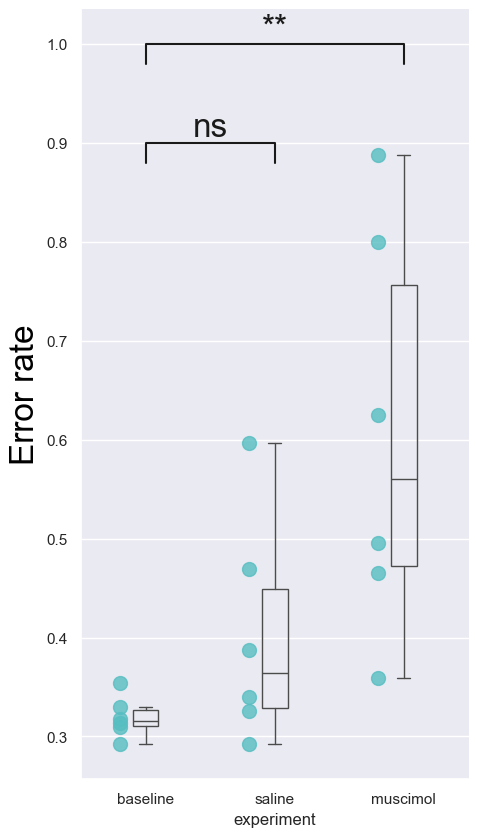

In [10]:
#create dataframe for plot:


df_baseline = pd.DataFrame({'perfect score':1- np.array(b_means), 'experiment': 'baseline'})
df_saline = pd.DataFrame({'perfect score':1- np.array(c_means), 'experiment': 'saline'})
df_muscimol = pd.DataFrame({'perfect score':1- np.array(m_means), 'experiment': 'muscimol'})

df_perfect_score = pd.concat([df_baseline, df_saline, df_muscimol], ignore_index=True)

## plot 
fnt = 24
darkorange =  "#dd8452" 
lightblue = "#8DB6CD" #"skyblue" # "#f1f7fb"
darkblue =  "#4682b4"
my_cmap = sns.set_palette(sns.color_palette([lightblue, darkblue, darkorange]))
order = ["baseline", "saline", "muscimol"]

plt.figure(figsize=(5, 10))
ax = sns.boxplot(x="experiment", y="perfect score", linewidth=1, saturation = 1, data=df_perfect_score, 
                 order=order,  showfliers=False, palette = my_cmap, width = 0.2,
                 medianprops={"linewidth": 1, "solid_capstyle": "butt"},boxprops = {"facecolor": 'none'}) 

ax.plot([-.2]*len(df_perfect_score[df_perfect_score.experiment == 'baseline']['perfect score']),df_perfect_score[df_perfect_score.experiment == 'baseline']['perfect score'],'o',color = '#56BEC1',markersize = 10,alpha = 0.8)
ax.plot([0.8]*len(df_perfect_score[df_perfect_score.experiment == 'saline']['perfect score']),df_perfect_score[df_perfect_score.experiment == 'saline']['perfect score'],'o',color = '#56BEC1',markersize = 10,alpha = 0.8)
ax.plot([1.8]*len(df_perfect_score[df_perfect_score.experiment == 'muscimol']['perfect score']),df_perfect_score[df_perfect_score.experiment == 'muscimol']['perfect score'],'o',color = '#56BEC1',markersize = 10,alpha = 0.8)




# statistical annotation
x1, x2 = 0, 1   # columns
y, h, col = 0.88, 0.02, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col, clip_on = False)
plt.text((x1+x2)*.5, y+h, "ns", ha='center', va='bottom', color=col, clip_on = False, fontsize = fnt)
#plt.text((x1+x2)*.5, y-(h*+3), " p < 0.05", ha='center', va='bottom', color=col, clip_on = False, fontsize = fnt)

x1, x2 = 0, 2   # columns
y, h, col = 0.98, 0.02, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col, clip_on = False)
plt.text((x1+x2)*.5, y+h, "**", ha='center', va='bottom', color=col, clip_on = False, fontsize = fnt)



sns.set_theme(style="white", font_scale = 1.3)
plt.ylabel("Error rate", c = "black", fontsize = fnt) #"Culmen Length (mm)",fontweight ='bold', size=14)

# plt.ylim([0, 0.86])
sns.despine()
sns.set_style('ticks')


# SaveFig(r'Muscimol_Striatal_error_rate.pdf', r'Z:\projects\Emmett\Documents\writeup\fig2_striatum_muscimol\figs\\')
# plt.show()

In [11]:
### stats on above plot

from scipy import stats

stats_data = df_perfect_score
means = stats_data.groupby('experiment').mean()
sdevs = stats_data.groupby('experiment').std()
print("means",means)
print("\nsdevs:", sdevs)

values_y_axis = 'perfect score'
values_x_axis = 'experiment'
baseline_group = stats_data[stats_data[values_x_axis]=='baseline']
baseline_group = baseline_group[values_y_axis]
saline_group = stats_data[stats_data[values_x_axis]=='saline']
saline_group = saline_group[values_y_axis]
AP5_group = stats_data[stats_data[values_x_axis]=='muscimol']
AP5_group = AP5_group[values_y_axis]


fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.hist(AP5_group, bins=10, histtype='bar', color =darkorange) 
ax2.hist(saline_group, bins=10, histtype='bar', color=darkblue) 
plt.close()
#plt.show()



#Shapiro-Wilk test for nromality 
b_SW = stats.shapiro(baseline_group)
s_SW = stats.shapiro(saline_group) #W value, p value
a_SW = stats.shapiro(AP5_group)
print('\nSW test Baseline group:', b_SW)
print('SW test Saline group:',s_SW)
print('SW test AP5 group:',a_SW)
print("\na p value <0.05 shows non-normality i.e. oberservations in the group is not normally distributed")

#Bartlett's test for equal variance
from scipy.stats import bartlett
stat, p = bartlett(baseline_group, saline_group, AP5_group)
print("\nstat", stat, ", p", p)
# #Levene's test centered at the median #recommended for skewed distributions.
# lev_test_median = stats.levene(saline_group, AP5_group, center='median')
# print("\nlev_test_median:", lev_test_median)

# #Levene's test centered at the mean #recommended for symmetric, moderate-tailed distributions.
# lev_test_mean = stats.levene(saline_group, AP5_group, center='mean')
# print("lev_test_mean:", lev_test_mean)
print("\na p value <0.05 shows significantly different variance between groups i.e. unequal variance between groups\n")


from scipy.stats import f_oneway

#perform one-way ANOVA
print(f_oneway(baseline_group, saline_group, AP5_group))


import statsmodels.stats.multicomp as mc

comp = mc.MultiComparison(stats_data[values_y_axis], stats_data[values_x_axis])
post_hoc_res = comp.tukeyhsd()
print("\n",post_hoc_res.summary())

# print(stats.ttest_ind(saline_group,AP5_group))
# #print(stats.ttest_rel(saline_group,AP5_group))
# print(stats.mannwhitneyu(saline_group, AP5_group, alternative='two-sided'))


means             perfect score
experiment               
baseline         0.319412
muscimol         0.605498
saline           0.401774

sdevs:             perfect score
experiment               
baseline         0.020682
muscimol         0.205096
saline           0.113479

SW test Baseline group: ShapiroResult(statistic=0.9560245871543884, pvalue=0.7886388897895813)
SW test Saline group: ShapiroResult(statistic=0.896720290184021, pvalue=0.35490697622299194)
SW test AP5 group: ShapiroResult(statistic=0.9431118965148926, pvalue=0.6843602657318115)

a p value <0.05 shows non-normality i.e. oberservations in the group is not normally distributed

stat 15.156667286913807 , p 0.000511412709291878

a p value <0.05 shows significantly different variance between groups i.e. unequal variance between groups

F_onewayResult(statistic=7.0507031310752, pvalue=0.006939523075005052)

   Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1   group2  meandiff p-adj   lower  upper  reject
-----

In [12]:
### cut out the muscimol data by the defined timecut. Merge the data from all th sessions for each animal. but still keep animals seperate 

trial_split_data = dict(tuple(df.groupby('group')))


M_split_data = dict(tuple(trial_split_data['Muscimol'].groupby('session'))) 

m_cut_transits = []
m_cut_startpoketimes = []
m_cut_latency = []
m_cut_trials= []

m1_uncut_transits = []
m1_uncut_startpoketimes = []
m1_uncut_trials = []

for index,item in enumerate(M_split_data):
    for index, row in M_split_data[item].reset_index().iterrows():

    #     cut_time = m1_cut_time[index] * 60
        cut_time = 60 * 60

        start_poke_times = np.array(row.start_poke_times[0])
        transitions = np.array(row.transitions[0])
        latency = np.array(row.latency[0])
        trials = np.array(row.trial_id[0]) 
        time_filter = np.array(row.latency[0]) < 2 

        filtered_transitions = transitions[time_filter]
        filtered_start_poke_times = start_poke_times[time_filter]
        filtered_latency = latency[time_filter]
        filtered_trials = trials[time_filter]

        cut_inds = [np.where(filtered_start_poke_times < cut_time)]

        m_cut_transits = m_cut_transits + [list(filtered_transitions[cut_inds][0])]
        m_cut_startpoketimes = m_cut_startpoketimes + [list(filtered_start_poke_times[cut_inds][0])]
        m_cut_latency = m_cut_latency + [list(filtered_latency[cut_inds][0])]
        m_cut_trials = m_cut_trials + [list(filtered_trials[cut_inds][0])]

        m1_uncut_transits = m1_uncut_transits + [list(filtered_transitions)]
        m1_uncut_startpoketimes = m1_uncut_startpoketimes + [list(filtered_start_poke_times)]
        m1_uncut_trials = m1_uncut_trials + [list(filtered_trials)]
    

    
## do the same for control data: 


control_cut_transits = []
control_cut_startpoketimes = []
control_cut_latency = []
control_cut_trials= []

control_uncut_transits = []
control_uncut_startpoketimes = []
control_uncut_trials = []

C_split_data = dict(tuple(trial_split_data['Saline'].groupby('session'))) 

for index,item in enumerate(C_split_data):
    for index, row in C_split_data[item].reset_index().iterrows():
        # #     cut_time = m1_cut_time[index] * 60
        #     cut_time = 50 * 60
            cut_time = 100000000 

            start_poke_times = np.array(row.start_poke_times[0])
            transitions = np.array(row.transitions[0])
            latency = np.array(row.latency[0])
            trials = np.array(row.trial_id[0]) 
            time_filter = np.array(row.latency[0]) < 2 

            filtered_transitions = transitions[time_filter]
            filtered_start_poke_times = start_poke_times[time_filter]
            filtered_latency = latency[time_filter]
            filtered_trials = trials[time_filter]

            cut_inds = [np.where(filtered_start_poke_times < cut_time)]

            control_cut_transits = control_cut_transits + [list(filtered_transitions[cut_inds][0])]
            control_cut_startpoketimes = control_cut_startpoketimes + [list(filtered_start_poke_times[cut_inds][0])]
            control_cut_latency = control_cut_latency + [list(filtered_latency[cut_inds][0])]
            control_cut_trials = control_cut_latency + [list(filtered_trials[cut_inds][0])]

            control_uncut_transits = control_uncut_transits + [list(filtered_transitions)]
            control_uncut_startpoketimes = control_uncut_startpoketimes + [list(filtered_start_poke_times)]
            control_uncut_trials = control_uncut_trials + [list(filtered_trials)]

In [13]:
## merge sessions:

c_cut_transits_merged = []
for ani in np.unique(c_animal):
    mask = np.array(c_animal) == ani
    sessions_ = list(np.array(control_cut_transits)[mask])
    merged_ = [item for sublist in sessions_ for item in sublist] 
    c_cut_transits_merged += [merged_]
    
m_cut_transits_merged = []
for ani in np.unique(m_animal):
    mask = np.array(m_animal) == ani
    sessions_ = list(np.array(m_cut_transits)[mask])
    merged_ = [item for sublist in sessions_ for item in sublist] 
    m_cut_transits_merged += [merged_]

# frormat heatmap data:
    
m_heatmaps = []
for i in range(len(m_cut_transits_merged)):
    m_heatmaps = m_heatmaps + [reversedata(determime_heatmapdata(determineTransitionNumber(m_cut_transits_merged[i])))]
    
c_heatmaps = []
for i in range(len(c_cut_transits_merged)):
    c_heatmaps = c_heatmaps + [reversedata(determime_heatmapdata(determineTransitionNumber(c_cut_transits_merged[i])))]

#average and normalise across animals 
m_av_heatmap = average_across_animals_transition_matrix(m_heatmaps)
c_av_heatmap = average_across_animals_transition_matrix(c_heatmaps)

######normalise data by column:
m_means_norm = normalise_transition_matrix_means(m_av_heatmap) 
c_means_norm = normalise_transition_matrix_means(c_av_heatmap) 

m_max = np.max(m_means_norm)
c_max = np.max(c_means_norm)

# d1 = np.array(c_means_norm[1]) - np.array(c_means_norm[2])
# d2 = np.array(l_means_norm[1]) - np.array(l_means_norm[2])
# d1_list = [list(d1.tolist())]
# d2_list = [list(d2.tolist())]

normalised_means = c_means_norm + m_means_norm

## create mask and labels
x_axis_labels = ['Port 1','Port 2','Port 3','Port 4'] # labels for x-axis
y_axis_labels = ['Port Z','Port Y','Port X','Port 5','Port 4','Port 3','Port 2','Port 1'] # labels for y-axis
labels =  np.array([['','','',''],
                    ['','','',''],
                    ['','','',''],
                    ['','','','T4'],
                    ['','','T3',''],
                    ['','T2','',''],
                    ['T1','','',''],
                    ['','','','']])

mask = np.zeros_like(normalised_means[0])

#plot:
title = ['control','muscimol']
with sns.axes_style("white"):
    nrow = 1 
    ncol = 2
    fig, axs = plt.subplots(nrow, ncol,figsize=(30, 20))
    for ind, ax in enumerate(fig.axes):
        if ind == 0:
            maximum = 0.7
        else:
            maximum = 0.7
            
        h1 = sns.heatmap(normalised_means[ind],xticklabels=x_axis_labels, yticklabels=y_axis_labels, 
                        linewidths=.5, mask=mask, square=True,cmap="YlGnBu",annot = labels,fmt = '',ax=ax,cbar_kws = dict(use_gridspec=False,location="right"), vmin = 0,vmax =0.7)

        ax.set_ylabel('End Port',size = 20)
        ax.set_xlabel('Start Port',size = 20)
        ax.set_title(title[ind], loc = 'left',pad = 20,fontsize = 20,color = 'firebrick')
    

# SaveFig('musci_heatmaps.pdf',r'Z:\projects\Emmett\Documents\writeup\fig2_thal_musccimol\figs\\')

SaveFig(r'Muscimol_Striatal_heatmap.pdf', r'Z:\projects\Emmett\Documents\writeup\fig2_striatum_muscimol\figs\\')

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23720\3656740721.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sessions_ = list(np.array(control_cut_transits)[mask])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23720\3656740721.py:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sessions_ = list(np.array(m_cut_transits)[mask])
C:\Users\Emmett\AppData\Local\Temp\ipykernel_23720\3724722692.py:115: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengt

In [14]:
m_errors = error_break_down(m_cut_transits_merged)
c_errors = error_break_down(c_cut_transits_merged)

# plt.style.use('default') 
titles = ['repeat','missequence','other']
ort = 'v'
fig,axs = plt.subplots(1, 3, figsize=(10, 5))
for ind, ax in enumerate(fig.axes):
            

        for i in range(len(c_errors[ind])):
            ax.plot([0.2,0.8],[c_errors[ind],m_errors[ind]],'o-',color =['#56BEC1','#56BEC1','#56BEC1'][ind],markeredgecolor = 'none',alpha = 1, markersize = 7,markeredgewidth=0)
            
        repeat_errors_df = pd.DataFrame({'group':['control'] * len(c_errors[ind]) + ['muscimol'] * len(m_errors[ind]),'error_rate': c_errors[ind] + m_errors[ind]})
            
        ax=sns.boxplot( x = 'group', y = 'error_rate', data = repeat_errors_df, color = '#56BEC1', width = .15, zorder = 10,\
        showcaps = True, boxprops = {'facecolor':'#56BEC1', "zorder":10,'linewidth':1},\
        showfliers=False, whiskerprops = {'color':'#56BEC1','linewidth':1, "zorder":10},\
           saturation = 1, orient = ort, ax = ax)
        

        ax.set_xlim([-0.5, 1.5])
        ax.set_ylim([0, 0.6])
        
        ax.set_title(titles[ind], loc = 'left',fontsize = 20,pad = 30, color = 'k')
        
SaveFig(r'Muscimol_Striatal_error_breakdown.pdf', r'Z:\projects\Emmett\Documents\writeup\fig2_striatum_muscimol\figs\\')

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [17]:
error_break_down

<function __main__.error_break_down(m_cut_transits)>

In [ ]:
## stats on above plot

#Shapiro-Wilk test for nromality 
sr_SW = stats.shapiro(c_errors[0]) #W value, p value
sm_SW = stats.shapiro(c_errors[1])
so_SW = stats.shapiro(c_errors[2]) #W value, p value
mr_SW = stats.shapiro(m_errors[0])
mm_SW = stats.shapiro(m_errors[1]) #W value, p value
mo_SW = stats.shapiro(m_errors[2])
print('\nSW test Baseline group:', b_SW)
print('SW test Saline group:',s_SW)
print('SW test AP5 group:',a_SW)
print("\na p value <0.05 shows non-normality i.e. oberservations in the group is not normally distributed")

#Bartlett's test for equal variance
from scipy.stats import bartlett
stat, p = bartlett(c_errors[0],c_errors[1],c_errors[2],m_errors[0],m_errors[1],m_errors[2])
print("\nstat", stat, ", p", p)

from scipy.stats import f_oneway
#perform one-way ANOVA
print(f_oneway(c_errors[0],c_errors[1],c_errors[2],m_errors[0],m_errors[1],m_errors[2]))

print('rel t test repeats')
print(scipy.stats.ttest_rel(c_errors[0],m_errors[0]))


import statsmodels.stats.multicomp as mc

comp = mc.MultiComparison(c_errors[0] + c_errors[1] + c_errors[2] + m_errors[0] + m_errors[1] + m_errors[2], ['control_repeats']*len(c_errors[0]) + ['control_misseq']*len(c_errors[1]) + ['control_other']*len(c_errors[2]) + ['muscimol_repeats']*len(m_errors[0]) + ['muscimol_misseq']*len(m_errors[1]) + ['muscimol_other']*len(m_errors[2]))
post_hoc_res = comp.tukeyhsd()
print("\n",post_hoc_res.summary())

# print(stats.ttest_ind(saline_group,AP5_group))
# #print(stats.ttest_rel(saline_group,AP5_group))
# print(stats.mannwhitneyu(saline_group, AP5_group, alternative='two-sided'))

NameError: name 'c_errors' is not defined

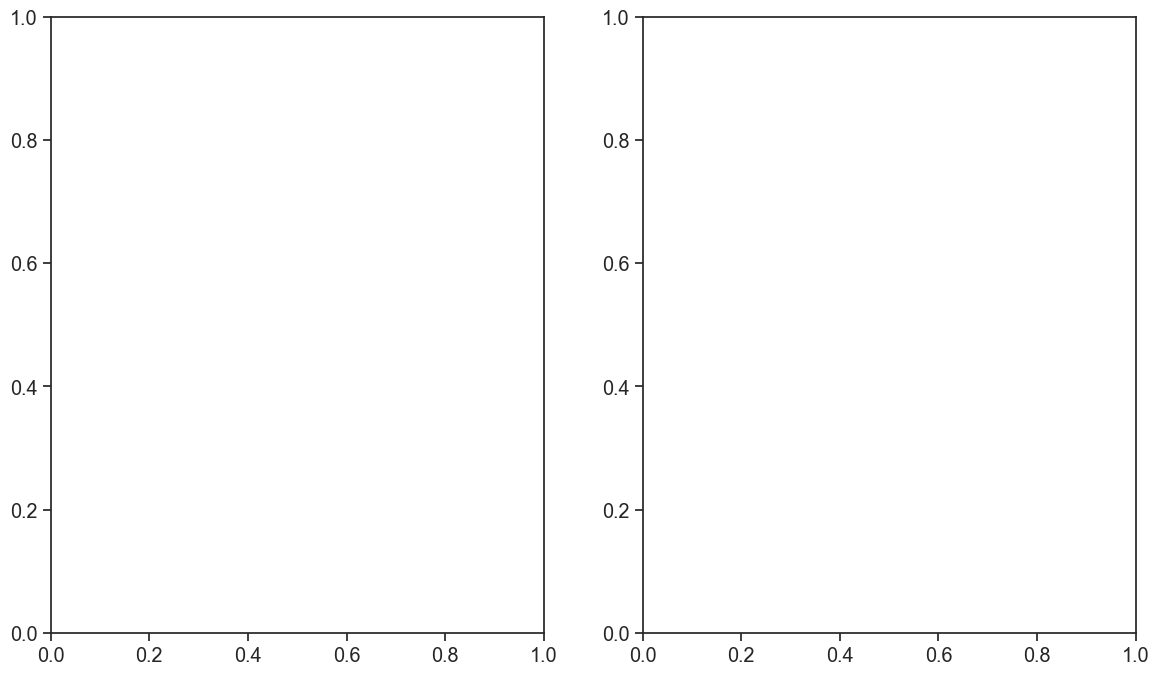

In [15]:
fig,[ax,ax1] = plt.subplots(1, 2, figsize=(14, 8))

explode = (0.02, 0.02, 0.02)
colors = ['#8DCBB8','#315EA7','#242D5B']

prerepeat_mean = np.mean(c_errors[0])
premisseq_mean = np.mean(c_errors[1])
preother_mean= np.mean(c_errors[2])
total_prop = prerepeat_mean + premisseq_mean + preother_mean

y = np.array([prerepeat_mean/total_prop, premisseq_mean/total_prop,preother_mean/total_prop])
mylabels = ["Repeat", "Missequence", "Other" ]

ax.pie(y, labels = mylabels,explode =explode, colors=colors )

Postrepeat_mean = np.mean(m_errors[0])
Postmisseq_mean = np.mean(m_errors[1])
Postother_mean= np.mean(m_errors[2])
total_prop = Postrepeat_mean + Postmisseq_mean + Postother_mean

y2 = np.array([Postrepeat_mean/total_prop, Postmisseq_mean/total_prop,Postother_mean/total_prop])
mylabels = ["Repeat", "Missequence", "Other" ]

ax1.pie(y2, labels = mylabels,explode =explode,colors=colors )

prerepeat_sem = scipy.stats.sem(c_errors[0])
premisseq_sem = scipy.stats.sem(c_errors[1])
preother_sem= scipy.stats.sem(c_errors[2])
Postrepeat_sem = scipy.stats.sem(m_errors[0])
Postmisseq_sem = scipy.stats.sem(m_errors[1])
Postother_sem= scipy.stats.sem(m_errors[2])

print('repeat pre-proportion = ' + str(y[0]*100) + '   SEM = ' + str(prerepeat_sem*100))
print('misseq pre-proportion = ' + str(y[1]*100) + '   SEM = ' + str(premisseq_sem*100))
print('other pre-proportion = ' + str(y[2]*100) + '   SEM = ' + str(preother_sem*100))
print('-----------------')
print('repeat post-proportion = ' + str(y2[0]*100) + '   SEM = ' + str(Postrepeat_sem*100))
print('misseq post-proportion = ' + str(y2[1]*100) + '   SEM = ' + str(Postmisseq_sem*100))
print('other post-proportion = ' + str(y2[2]*100) + '   SEM = ' + str(Postother_sem*100))
      
# SaveFig('error_rate_proportions.pdf',r'Z:\projects\Emmett\Documents\writeup\fig2_thal_musccimol\figs\\')

In [18]:
## for each session pull out all the first ports that was entered, for the last transiton also take the second one as it wont appear in a subsequent transition
AA_port_proportions= []

for animal in range(len(m_cut_transits_merged)):
    ports= []
    for index, transit in enumerate(np.array(m_cut_transits_merged[animal])):
        ports = ports + [int(str(transit)[0])]
        if index == len(np.array(m_cut_transits_merged[animal]))-1:
            ports = ports + [int(str(transit)[-1])]
    port_proportions=['muscimol']
    for i in range(1,9):
        port_proportions = port_proportions + [sum(np.array(ports) == i)/len(ports)]
    AA_port_proportions = AA_port_proportions + [port_proportions]
    
M_poke_proportions_df = pd.DataFrame(AA_port_proportions, columns = ['group','p1','p2','p3','p4','p5','p6','p7','p8'])
    
## same for control
AA_port_proportions= []
for animal in range(len(c_cut_transits_merged)):
    ports= []
    for index, transit in enumerate(np.array(c_cut_transits_merged[animal])):
        ports = ports + [int(str(transit)[0])]
        if index == len(np.array(c_cut_transits_merged[animal]))-1:
            ports = ports + [int(str(transit)[-1])]
    port_proportions=['control']
    for i in range(1,9):
        port_proportions = port_proportions + [sum(np.array(ports) == i)/len(ports)]
    AA_port_proportions = AA_port_proportions + [port_proportions]
    
C_poke_proportions_df = pd.DataFrame(AA_port_proportions, columns = ['group','p1','p2','p3','p4','p5','p6','p7','p8'])



nrow = 1 
ncol = 2
fig, axs = plt.subplots(nrow, ncol,figsize=(20, 10))
for ind, ax in enumerate(fig.axes):
    
    if ind == 0:
        poke_proportions_df = C_poke_proportions_df
    else:
        poke_proportions_df = M_poke_proportions_df
        

    ax.set_ylim([0, 5])
    ax.set_xlim([0, 5])


    M_poke_proportions_df

    colormap = plt.cm.get_cmap('YlGnBu') # 'plasma' or 'viridis'


    color_vals = [np.mean(poke_proportions_df.p1),np.mean(poke_proportions_df.p2),np.mean(poke_proportions_df.p3),np.mean(poke_proportions_df.p4),
                  np.mean(poke_proportions_df.p5),np.mean(poke_proportions_df.p6),np.mean(poke_proportions_df.p7),np.mean(poke_proportions_df.p8)]

    normalised_colour = np.array(color_vals)/max(color_vals)

    x = [1,2,3,4,1,2,3,4]
    y = [2,2,2,2,3.2,3.2,3.2,3.2]

    circles_ = []
    for i in range(8):
        color_ = colormap(normalised_colour[i])
        circles_ = circles_ + [plt.Circle((x[i], y[i]), 0.4,fill=True, linewidth=5, color = color_)]
    for i in range(8):
        ax.add_artist(circles_[i])

    plt.axis('off')
    plt.text(0.7,1,('Port_Poke_proportions for Session '), horizontalalignment='left', size=20)





    # sc = plt.scatter(x, y, c=colors)

    sm = plt.cm.ScalarMappable(cmap=colormap)
    sm.set_clim(vmin=0, vmax=max(color_vals))
    ax.text(5,1,('max val is '+ str(max(color_vals))),size=10)

    plt.colorbar(sm,fraction=0.02, pad=0.04)


    poke_data = [poke_proportions_df.p1.values,poke_proportions_df.p2.values,poke_proportions_df.p3.values,poke_proportions_df.p4.values,
                  poke_proportions_df.p5.values,poke_proportions_df.p6.values,poke_proportions_df.p7.values,poke_proportions_df.p8.values]


    # SaveFig('PokeProportions.svg',r'Z:\projects\Emmett\Documents\writeup\fig1_behaviour_figures\figs\\')


    SEM = [scipy.stats.sem(poke_proportions_df.p1),scipy.stats.sem(poke_proportions_df.p2),scipy.stats.sem(poke_proportions_df.p3),scipy.stats.sem(poke_proportions_df.p4),
                  scipy.stats.sem(poke_proportions_df.p5),scipy.stats.sem(poke_proportions_df.p6),scipy.stats.sem(poke_proportions_df.p7),scipy.stats.sem(poke_proportions_df.p8)]

    if ind == 0:
        print('CONTROL')
    else:
        print('MUSCIMOL')
    print('mean ratios per port: ' + str(np.array(color_vals)*100))
    print('SEM per port: ' + str(np.array(SEM)*100)) 
    
# SaveFig(r'Muscimol_Striatal_pokeprops.pdf', r'Z:\projects\Emmett\Documents\writeup\fig2_striatum_muscimol\figs\\')

C:\Users\Emmett\AppData\Local\Temp\ipykernel_23720\1322642613.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  for index, transit in enumerate(np.array(m_cut_transits_merged[animal])):


ValueError: invalid literal for int() with base 10: '['

In [258]:
## merge sessions:

c_cut_latencies_merged = []
for ani in np.unique(c_animal):
    mask = np.array(c_animal) == ani
    sessions_ = list(np.array(control_cut_latency)[mask])
    merged_ = [item for sublist in sessions_ for item in sublist] 
    c_cut_latencies_merged += [merged_]
    
m_cut_latencies_merged = []
for ani in np.unique(m_animal):
    mask = np.array(m_animal) == ani
    sessions_ = list(np.array(m_cut_latency)[mask])
    merged_ = [item for sublist in sessions_ for item in sublist] 
    m_cut_latencies_merged += [merged_]

<ipython-input-258-de4988eb2844>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sessions_ = list(np.array(control_cut_latency)[mask])
<ipython-input-258-de4988eb2844>:13: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sessions_ = list(np.array(m_cut_latency)[mask])


In [259]:

m_transition_means = []
m_transition_std = []
 
for index, animal_ in enumerate(m_cut_transits_merged):
    transitions = [21,16,63,37]
    transition_times = []
    for i,transit in enumerate(transitions):
        inds = np.where(np.array(animal_) == transit)
        transition_times = transition_times + list(np.array(m_cut_latencies_merged[index])[inds])
    m_transition_means = m_transition_means + [np.mean(transition_times)]
    m_transition_std = m_transition_std + [np.std(transition_times)]
    
    
c_TransitionTypes_flattened = [item for sublist in c_cut_transits_merged for item in sublist] 
c_TransitionTimes_flattened = [item for sublist in c_cut_latencies_merged for item in sublist] 

c_transition_means = []
c_transition_std = []
for index, animal_ in enumerate(c_cut_transits_merged):
    transitions = [21,16,63,37]
    
    transition_times = []
    for i,transit in enumerate(transitions):
        inds = np.where(np.array(animal_) == transit)
        transition_times = transition_times + list(np.array(c_cut_latencies_merged[index])[inds])

    c_transition_means = c_transition_means + [np.mean(transition_times)]
    c_transition_std = c_transition_std+ [np.std(transition_times)]


    

In [261]:
#transition times

ort = 'v'

fig,ax = plt.subplots(1, 1, figsize=(5, 10))
for i in range(len(m_transition_means)):
    ax.plot((0.2,0.8),(c_transition_means[i],m_transition_means[i]),'o-',color ='#56BEC1',markeredgecolor = 'none',alpha = 1, markersize = 15,markeredgewidth=0)
#     ax.plot([*len(post_transition_means[i]),post_transition_means[i],'o',color ='#56BEC1',markeredgecolor = 'none',alpha = 1, markersize = 9,markeredgewidth=0)

    plot_df = pd.DataFrame({'PrePost':['pre']*len(c_transition_means) + ['post']*len(m_transition_means) ,'mean_latency': c_transition_means + m_transition_means})

    ax=sns.boxplot( x = 'PrePost', y = 'mean_latency', data = plot_df, color = '#56BEC1', width = .15, zorder = 10,\
    showcaps = True, boxprops = {'facecolor':'#56BEC1', "zorder":10,'linewidth':1},\
    showfliers=False, whiskerprops = {'linewidth':1, "zorder":10},\
       saturation = 1, orient = ort, ax = ax)

    
#     ax.set_ylim([0.2, 1.2])
    
# print('post' + str(i))
# print(scipy.stats.normaltest(pre_transition_std))

# print('pre' + str(i))
# print(scipy.stats.normaltest(post_transition_std))

print('---- too few samples, assumed normal')

print(scipy.stats.ttest_rel(c_transition_means,m_transition_means))

SaveFig(r'Muscimol_Striatal_transit latencies.pdf', r'Z:\projects\Emmett\Documents\writeup\fig2_striatum_muscimol\figs\\')

---- too few samples, assumed normal
Ttest_relResult(statistic=-2.2545573768448475, pvalue=0.07385372788483961)


In [263]:
#transition variability

ort = 'v'

fig,ax = plt.subplots(1, 1, figsize=(5, 10))
for i in range(len(c_transition_std)):
    ax.plot((0.2,0.8),(c_transition_std[i],m_transition_std[i]),'o-',color ='#56BEC1',markeredgecolor = 'none',alpha = 1, markersize = 15,markeredgewidth=0)
#     ax.plot([*len(post_transition_means[i]),post_transition_means[i],'o',color ='#56BEC1',markeredgecolor = 'none',alpha = 1, markersize = 9,markeredgewidth=0)

    plot_df = pd.DataFrame({'PrePost':['pre']*len(c_transition_std) + ['post']*len(m_transition_std) ,'mean_latency': c_transition_std + m_transition_std})

    ax=sns.boxplot( x = 'PrePost', y = 'mean_latency', data = plot_df, color = '#56BEC1', width = .15, zorder = 10,\
    showcaps = True, boxprops = {'facecolor':'#56BEC1', "zorder":10,'linewidth':1},\
    showfliers=False, whiskerprops = {'linewidth':1, "zorder":10},\
       saturation = 1, orient = ort, ax = ax)

    
    ax.set_ylim([0, 0.6])


# print('post' + str(i))
# print(scipy.stats.normaltest(pre_transition_std))

# print('pre' + str(i))
# print(scipy.stats.normaltest(post_transition_std))

print('---- too few samples, assumed normal')

print(scipy.stats.ttest_rel(c_transition_std,m_transition_std))
    
SaveFig(r'Muscimol_Striatal_transit_standarddevs.pdf', r'Z:\projects\Emmett\Documents\writeup\fig2_striatum_muscimol\figs\\')

---- too few samples, assumed normal
Ttest_relResult(statistic=-0.9321399964443517, pvalue=0.3940509440956597)


In [94]:
dark_pink = '#BE575F'
dark_blue = '#232C56'

musci_temp = []
for index in range(len(data[muscimol_mask].pscores.values)):
    lesions_temp.append((data[lesion_mask][l_pre_mask].pscores.values[index] + data[lesion_mask][l_post_mask].pscores.values[index])[0:6])
    



Cmeans = []
Cst_devs = []
for item in conactinate_nth_items(controls_temp):
    Cmeans = Cmeans + [np.mean(item)]
    Cst_devs = Cst_devs + [np.std(item)]
    
Lmeans = []
Lst_devs = []
for item in conactinate_nth_items(lesions_temp):
    Lmeans = Lmeans + [np.mean(item)]
    Lst_devs = Lst_devs + [np.std(item)]

nrow = 1 
ncol = 1
counter = 0
fig, axs = plt.subplots(nrow, ncol,figsize=(20, 10))
for ind, ax in enumerate(fig.axes):
    ax.errorbar(np.linspace(0,5,6)-0.05,Cmeans,Cst_devs,marker = 'o',linestyle = '-',color = dark_blue, alpha = 1, markersize = 15)
    ax.errorbar(np.linspace(0,5,6)+0.05,Lmeans,Lst_devs,marker = 'o',linestyle = '-',color = dark_pink, alpha = 1, markersize = 15)
    
ax.set_xticklabels(('','-3', '-2', '-1', '+1', '+2','+3'), fontsize = 15)

ax.set_ylabel('P-Score',fontsize = 20)
ax.set_xlabel('Session before/after lesion',fontsize = 20)

ax.tick_params(axis='both', which='major', labelsize=30)
ax.set_title('Perfect scores',loc = 'left',fontsize = 20,pad = 50)

ax.set_ylim([0, 1])
    
# # ax.axvspan(-0.25, 2.25, alpha=0.1, facecolor= 'grey')
ax.axvspan(2.2, 2.8, alpha=0.3, facecolor= 'grey')

ax.text(2.25,1.03,'10 day gap', fontsize = 20)

ax.text(6,0.55,'Lesion', fontsize = 30, color = dark_pink)
ax.text(6,0.45,'Control', fontsize = 30,color = dark_blue)

# SaveFig('Performance_pre_post.svg',r'Z:\projects\Emmett\Documents\writeup\fig1_striatum_lesions\figs\\')



from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

control_ = []
for index,item in enumerate(conactinate_nth_items(controls_temp)):
    print('control' + str(index+1))
    control_= control_ + [item]
    print(scipy.stats.normaltest(item))
lesion_ = []
for index,item in enumerate(conactinate_nth_items(lesions_temp)):
    print('lesion' + str(index+1))
    lesion_= lesion_ + [item]
#     print(scipy.stats.normaltest(item))
print('--------')
print('cant test lesion data as only 7 samples per session and 8 needed for normality test - assumed normally distributed')
print('----- ANOVA:')
print(scipy.stats.f_oneway(control_[0],control_[1],control_[2],lesion_[0],lesion_[1],lesion_[2],control_[3],control_[4],control_[5],lesion_[3],lesion_[4],lesion_[5]))


#create DataFrame to hold data
df = pd.DataFrame({'score': control_[0] + control_[1] +control_[2]+lesion_[0]+lesion_[1]+lesion_[2]+control_[3]+control_[4]+control_[5]+lesion_[3]+lesion_[4]+lesion_[5],
                   'group': list(np.repeat(['c_pre1', 'c_pre2', 'c_pre3'], repeats=8)) + list(np.repeat(['l_pre1', 'l_pre2', 'l_pre3'], repeats=7)) + list(np.repeat(['c_post1', 'c_post2', 'c_post3'], repeats=8)) + list(np.repeat(['l_post1', 'l_post2', 'l_post3'], repeats=7))}) 
# perform Tukey's test
tukey = pairwise_tukeyhsd(endog=df['score'],
                          groups=df['group'],
                          alpha=0.05)
#display results
print(tukey)


IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
## load in data

data = pd.DataFrame({'Group':[],'mean':[], 'latencies':[],'standard dev':[], 'latencies':[],'error scores':[],'error breakdown [seq,spatial,repeat,other]':[],'pscores':[],'tscores':[],'transition_matrix':[],'animal':[],'type':[]})

paths = glob.glob(PATH + '\*\Muscimol\\')
for path in paths:
    os.listdir(path) 
    for file in os.listdir(path):
        if 'data' in file:
            print(path)
            with open (path + file , 'rb') as fp:
                dat = pickle.load(fp)  
                dat['animal'] = [path.split('\\')[-3]]*3
                dat['type'] = [file_]*3
                data = data.append(dat)


In [37]:
m_means = []
for item in data[muscimol_mask].pscores:
    m_means += [np.mean(item)]
c_means = []
for item in data[saline_mask].pscores:
    c_means += [np.mean(item)]
b_means = []
for item in data[baseline_mask].pscores:
    b_means += [np.mean(item)]

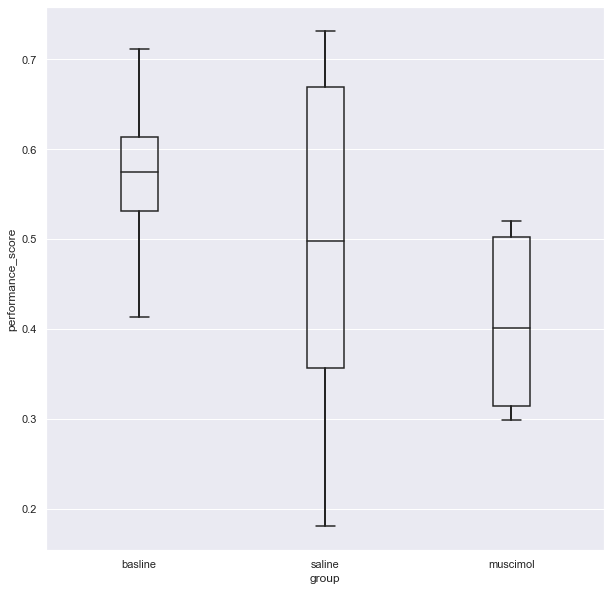

In [38]:
  
fig, ax = plt.subplots(1, 1,figsize=(10,10))

scores = b_means + c_means + m_means
type_ = ['basline']*len(b_means) + ['saline']*len(c_means) + ['muscimol']*len(m_means)
plot_df = pd.DataFrame({'group': type_, 'performance_score': scores})

ax=sns.boxplot( y = 'performance_score', x = 'group', data = plot_df, color = dark_blue, width = .2, zorder = 10,\
            showcaps = True, boxprops = {'facecolor':'none', "zorder":10},\
            showfliers=False, whiskerprops = {'linewidth':2, "zorder":10},\
               saturation = 1, orient = 'v',ax = ax)

for i in range(len(pre_c_means)):
    plt.plot([0.3,0.7],[pre_c_means[i],post_c_means[i]],'o-',color = dark_blue, alpha = 1, markersize = 12,markeredgewidth=0)
for i in range(len(pre_l_means)):
    plt.plot([2.3,2.7],[pre_l_means[i],post_l_means[i]],'o-',color = '#56BEC1', alpha = 1, markersize = 12,markeredgewidth=0)
    

# SaveFig('Performance_pre_post_boxplots.svg',r'Z:\projects\Emmett\Documents\writeup\fig1_striatum_lesions\figs\\')

In [971]:
for i in range(7):

    print('c data point' + str(i))
    print(scipy.stats.normaltest(controls_temp[i]))
    
    print('l data point' + str(i))
    print(scipy.stats.normaltest(lesions_temp[i]))
    
    print('----')

c data point0


ValueError: skewtest is not valid with less than 8 samples; 6 samples were given.

In [ ]:
#stats
print('control stats:')
if scipy.stats.normaltest(list(plot_df.error_rate[cb_mask]) + list(plot_df.error_rate[cl_mask]))[-1] > 0.05:
    print('data is normally distributed')
else:
    print('data is not normally distributed')
print(scipy.stats.ttest_rel(plot_df.error_rate[cb_mask],plot_df.error_rate[cl_mask]))
print('---------')
#stats
print('lesion stats:')
if scipy.stats.normaltest(list(plot_df.error_rate[lb_mask]) + list(plot_df.error_rate[ll_mask]))[-1] > 0.05:
    print('data is normally distributed')
else:
    print('data is not normally distributed')
print(scipy.stats.ttest_rel(plot_df.error_rate[lb_mask],plot_df.error_rate[ll_mask]))

# SaveFig('error_rate.svg',r'Z:\projects\Emmett\Documents\writeup\fig1_striatum_lesions\figs\\')

In [ ]:

c_all_tmatrix = [data[control_mask][c_early_learning_mask].transition_matrix.values,data[control_mask][c_pre_mask].transition_matrix.values,data[control_mask][c_post_mask].transition_matrix.values]
l_all_tmatrix = [data[lesion_mask][l_early_learning_mask].transition_matrix.values,data[lesion_mask][l_pre_mask].transition_matrix.values,data[lesion_mask][l_post_mask].transition_matrix.values]

C_group_means = average_across_animals_transition_matrix(c_all_tmatrix)
L_group_means = average_across_animals_transition_matrix(l_all_tmatrix)


######normalise data by column:
c_means_norm = normalise_transition_matrix_means(C_group_means) 
l_means_norm = normalise_transition_matrix_means(L_group_means) 

c_max = np.max(c_means_norm)
l_max = np.max(l_means_norm)

d1 = np.array(c_means_norm[1]) - np.array(c_means_norm[2])
d2 = np.array(l_means_norm[1]) - np.array(l_means_norm[2])
d1_list = [list(d1.tolist())]
d2_list = [list(d2.tolist())]

normalised_means = c_means_norm + l_means_norm

## create mask and labels
x_axis_labels = ['Port 1','Port 2','Port 3','Port 4'] # labels for x-axis
y_axis_labels = ['Port Z','Port Y','Port X','Port 5','Port 4','Port 3','Port 2','Port 1'] # labels for y-axis
labels =  np.array([['','','',''],
                    ['','','',''],
                    ['','','',''],
                    ['','','','T4'],
                    ['','','T3',''],
                    ['','T2','',''],
                    ['T1','','',''],
                    ['','','','']])

mask = np.zeros_like(normalised_means[0])

#plot:
title = ['Early Learning','Baseline','Control','Early Learning','Baseline','Lesion']
with sns.axes_style("white"):
    nrow = 2 
    ncol = 3
    counter = 0
    fig, axs = plt.subplots(nrow, ncol,figsize=(30, 20))
    for ind, ax in enumerate(fig.axes):
        if counter < 3:
            maximum = c_max
        else:
            maximum = l_max
        h1 = sns.heatmap(normalised_means[counter],xticklabels=x_axis_labels, yticklabels=y_axis_labels, 
                        linewidths=.5, mask=mask, square=True,cmap="YlGnBu",annot = labels,fmt = '',ax=ax,cbar_kws = dict(use_gridspec=False,location="right"), vmin = 0,vmax = 0.8)

        ax.set_ylabel('End Port',size = 20)
        ax.set_xlabel('Start Port',size = 20)
        ax.set_title(title[counter], loc = 'left',pad = 20,fontsize = 20,color = 'firebrick')
        counter = counter + 1
    


    
# SaveFig('Lesions_heatmaps.svg',r'Z:\projects\Emmett\Documents\writeup\fig1_striatum_lesions\figs\\')

In [ ]:
import matplotlib.colors as clr

d1 = np.array(c_means_norm[2]) - np.array(c_means_norm[1])
d2 = np.array(l_means_norm[2]) - np.array(l_means_norm[1])
d1_list = [list(d1.tolist())]
d2_list = [list(d2.tolist())]

difference = d1_list + d2_list

maximum = max(np.max(d1_list),np.max(d2_list))
minimum = min(np.min(d1_list),np.min(d2_list))

# colors = ['#285CA6','#F4F4F4','#BE575F']
# colors = ['#232C56','#F4F4F4','#BE575F']
          #,'#219CC1','#A4D3B6','#ECEFB6','#E6BFC4']
#56BEC1
colors = ['#56BEC1','#F4F4F4','#232C56']

cmap = clr.LinearSegmentedColormap.from_list('custom blue', colors, N=256)

title = ['Control Difference','Lesion Difference']

with sns.axes_style("white"):
    
    nrow = 1 
    ncol = 2
    counter = 0
    fig, axs = plt.subplots(nrow, ncol,figsize=(30, 20))
    for ind, ax in enumerate(fig.axes):
       
        h1 = sns.heatmap(difference[counter],xticklabels=x_axis_labels, yticklabels=y_axis_labels, 
                        linewidths=.5, mask=mask, square=True,cmap=cmap,annot = labels,fmt = '',ax=ax,cbar_kws = dict(use_gridspec=False,location="right"),vmax=0.4, vmin = -0.4)

        ax.set_ylabel('End Port',size = 20)
        ax.set_xlabel('Start Port',size = 20)

        
        ax.set_title(title[counter], loc = 'left',pad = 20,fontsize = 20,color = 'firebrick')
        counter = counter + 1
        
# SaveFig('heatmap_diff.svg',r'Z:\projects\Emmett\Documents\writeup\fig1_striatum_lesions\figs\\')

In [987]:
data

,Group,mean,latencies,standard dev,error scores,"error breakdown [seq,spatial,repeat,other]",pscores,tscores,transition_matrix,animal,type,mean latencies,standard dev latencies
0,Early Learning,NaN,NaN,NaN,"[0.24671734623358674, 0.6710435383552177, 0.08...","[0.38722966014418125, 0.027806385169927908, 0....","[0.07294685990338164, 0.18518518518518517, 0.5...","[0.6280193236714975, 0.3333333333333333, 0.757...","[[5.0, 5.0, 5.0, 11.0], [0.0, 0.0, 0.0, 0.0], ...",EJT101,control,1.143258,0.430806
1,Pre Lesion,NaN,NaN,NaN,"[0.7438626774069812, 0.25182201764480244, 0.00...","[0.3480578827113481, 0.016374714394516376, 0.6...","[0.78125, 0.7881914893617022, 0.796108202443281]","[0.8595679012345679, 0.924468085106383, 0.9491...","[[5.0, 5.0, 4.0, 1.0], [0.0, 0.0, 0.0, 0.0], [...",EJT101,control,0.336717,0.125642
2,Post Lesion,NaN,NaN,NaN,"[0.7319931808495524, 0.25422645262111093, 0.01...","[0.4294495669181336, 0.03827884884045823, 0.51...","[0.7014035087719297, 0.636844331641286, 0.7362...","[0.9508771929824561, 0.9373096446700508, 0.926...","[[3.0, 5.0, 4.0, 8.0], [12.0, 32.0, 9.0, 5.0],...",EJT101,control,0.335876,0.130588
0,Early Learning,NaN,NaN,NaN,"[0.35364112327463115, 0.5654450261780105, 0.08...","[0.4511784511784512, 0.07996632996632996, 0.39...","[0.034482758620689655, 0.35760517799352753, 0....","[0.47413793103448276, 0.7103559870550161, 0.76...","[[0.0, 1.0, 5.0, 4.0], [7.0, 51.0, 18.0, 2.0],...",EJT147,control,1.089839,0.454202
1,Pre Lesion,NaN,NaN,NaN,"[0.8360157141046762, 0.1619566594854898, 0.002...","[0.30907668231611896, 0.03599374021909233, 0.6...","[0.9446666666666668, 0.9476695796920517, 0.822...","[0.978, 0.9950062421972534, 0.9946164199192463]","[[1.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 0.0], [...",EJT147,control,0.322709,0.106392
2,Post Lesion,NaN,NaN,NaN,"[0.8394107021901106, 0.1565816211334387, 0.004...","[0.3370583994232156, 0.16186012977649603, 0.48...","[0.9204946996466431, 0.9186567164179105, 0.714...","[0.9910875539850805, 0.9915422885572139, 0.977...","[[0.0, 2.0, 1.0, 2.0], [0.0, 0.0, 0.0, 0.0], [...",EJT147,control,0.311474,0.103548
0,Early Learning,NaN,NaN,NaN,"[0.3664, 0.5525333333333333, 0.08106666666666666]","[0.5154440154440154, 0.03185328185328185, 0.38...","[0.0, 0.2911392405063291, 0.6781914893617021]","[0.6182170542635659, 0.7246835443037974, 0.824...","[[3.0, 3.0, 3.0, 9.0], [8.0, 48.0, 14.0, 3.0],...",EJT148,control,1.008243,0.391170
1,Pre Lesion,NaN,NaN,NaN,"[0.732730692862368, 0.26267112550945765, 0.004...","[0.3666202506465088, 0.10105430674358465, 0.52...","[0.8040690104166667, 0.7470869746150645, 0.738...","[0.98125, 0.981751976695797, 0.9665717900063251]","[[2.0, 0.0, 2.0, 3.0], [9.0, 24.0, 7.0, 0.0], ...",EJT148,control,0.342301,0.132635
2,Post Lesion,NaN,NaN,NaN,"[0.6912518185843507, 0.3043203238661522, 0.004...","[0.35647474537518187, 0.08023279983371441, 0.5...","[0.7635741265344663, 0.7195238095238095, 0.697...","[0.9848048473402581, 0.9884920634920634, 0.982...","[[1.0, 2.0, 0.0, 3.0], [3.0, 17.0, 5.0, 1.0], ...",EJT148,control,0.352276,0.138421
0,Early Learning,NaN,NaN,NaN,"[0.3773319253783879, 0.5508623724040831, 0.071...","[0.4012779552715655, 0.05047923322683706, 0.51...","[0.057471264367816084, 0.2620772946859904, 0.7...","[0.4827586206896552, 0.7946859903381643, 0.907...","[[4.0, 8.0, 6.0, 4.0], [0.0, 0.0, 0.0, 0.0], [...",EJT174,control,0.969112,0.424482


In [ ]:
def extract_errors_into_df(input_):

    correct = []
    error = []
    other = []

    for i in range (3):
        for e in range(3):
            if e == 0:
                correct = correct + [list(np.array(input_[i])[:,e])]
            if e == 1:
                error = error + [list(np.array(input_[i])[:,e])]
            if e == 2:
                other = other + [list(np.array(input_[i])[:,e])]


    errors = pd.DataFrame({ 'Group':['Early','Pre', 'Post'], 'correct':  correct, 
        'error': error, 'other': other })
    return errors 



c_all_errors =  [l.tolist() for l in data[control_mask][c_early_learning_mask]['error scores'].values],[l.tolist() for l in data[control_mask][c_pre_mask]['error scores'].values],[l.tolist() for l in data[control_mask][c_post_mask]['error scores'].values]
l_all_errors =  [l.tolist() for l in data[lesion_mask][l_early_learning_mask]['error scores'].values],[l.tolist() for l in data[lesion_mask][l_pre_mask]['error scores'].values],[l.tolist() for l in data[lesion_mask][l_post_mask]['error scores'].values]

c_errors = extract_errors_into_df(c_all_errors)
l_errors = extract_errors_into_df(l_all_errors)


buzz = 'error'

fig, ax = plt.subplots(1, 1,figsize=(7,7))

for i in range(len(c_all_errors[0])):
    ax.plot([0.3,1.3],[c_errors[buzz][1][i],c_errors[buzz][2][i]],'o-',color = dark_blue, alpha = 1, markersize = 12,markeredgewidth=0)
for i in range(len(l_all_errors[0])):
    ax.plot([1.7,2.7],[l_errors[buzz][1][i],l_errors[buzz][2][i]],'o-',color = dark_pink,alpha = 1, markersize = 12,markeredgewidth=0)
    
scores = c_errors.error[1] + c_errors.error[2] + l_errors.error[1] + l_errors.error[2]
type_ = ['c_baseline']*len(c_errors.error[1]) + ['c_saline']*len(c_errors.error[2]) + ['l_Baseline']*len(l_errors.error[1]) + ['l_lesion']*len(l_errors.error[2])
plot_df = pd.DataFrame({'group': type_, 'error_rate': scores})

ax=sns.boxplot( y = 'error_rate', x = 'group', data = plot_df, color = dark_blue, width = .2, zorder = 10,\
            showcaps = True, boxprops = {'facecolor':'none', "zorder":10},\
            showfliers=False, whiskerprops = {'linewidth':2, "zorder":10},\
               saturation = 1, orient = 'v',ax = ax)
    
ax.set_xticks([0,1,2,3])
ax.set_xticklabels(('Baseline', 'Saline', 'Baseline', 'Lesion'), fontsize = 15)

ax.set_ylabel('Error proportions',fontsize = 30)

ax.tick_params(axis='both', which='major', labelsize=30)


cb_mask = plot_df.group == 'c_baseline'
cl_mask = plot_df.group == 'c_saline'
lb_mask = plot_df.group == 'l_Baseline'
ll_mask = plot_df.group == 'l_lesion'

#stats
print('control baseline')
print(scipy.stats.normaltest(list(plot_df.error_rate[cb_mask])))
print('control saline')
print(scipy.stats.normaltest(list(plot_df.error_rate[cl_mask])))
if (scipy.stats.normaltest(list(plot_df.error_rate[cb_mask]))[-1] > 0.5) and (scipy.stats.normaltest(list(plot_df.error_rate[cl_mask]))[-1] > 0.5):
    print('data is normally distributed')
else:
    print('data is not normally distributed')
print(scipy.stats.ttest_rel(plot_df.error_rate[cb_mask],plot_df.error_rate[cl_mask]))
print('---------')

# print('lesion baseline')
# print(scipy.stats.normaltest(list(plot_df.error_rate[lb_mask])))
# print('lesion saline')
# print(scipy.stats.normaltest(list(plot_df.error_rate[ll_mask])))
# if (scipy.stats.normaltest(list(plot_df.error_rate[lb_mask]))[-1] > 0.5) and (scipy.stats.normaltest(list(plot_df.error_rate[ll_mask]))[-1] > 0.5):
#     print('data is normally distributed')
# else:
#     print('data is not normally distributed')
print('ony 7 data points, 8 needed for normlaity test, data assumed normal and paired t test done')
print(scipy.stats.ttest_rel(plot_df.error_rate[lb_mask],plot_df.error_rate[ll_mask]))






In [671]:
print('---------')
print('misseq stats:')
if scipy.stats.normaltest(Misseq_errors_df.error_rate.values)[-1] > 0.05:
    print('data is normally distributed')
else:
    print('data is not normally distributed')
print(scipy.stats.ttest_rel(Misseq_errors_df.error_rate[Misseq_errors_df.PrePost == 0],Misseq_errors_df.error_rate[Misseq_errors_df.PrePost == 1]))

print('---------')
print('other stats:')
if scipy.stats.normaltest(Other_errors_df.error_rate.values)[-1] > 0.05:
    print('data is normally distributed')
else:
    print('data is not normally distributed')
print(scipy.stats.ranksums(Other_errors_df.error_rate[Other_errors_df.PrePost == 0],Other_errors_df.error_rate[Other_errors_df.PrePost == 1]))

SyntaxError: invalid syntax (<ipython-input-671-b3d880b8c40b>, line 3)

In [939]:
def average_across_animals_transition_matrix(AA_transits):
    group_means = []
    for group in AA_transits:
        AA_data= []
        for animal in group:
            flat_list = [item for sublist in animal for item in sublist]
            normalised = list(np.array(flat_list) / max(flat_list))
            AA_data = AA_data + [normalised]
        concat_AA_data = conactinate_nth_items(AA_data)

        # recreate transition matrix: 
        means= [[]]*8
        count = 0
        index = 0
        for item in concat_AA_data:
            means[index] = means[index] + [np.mean(item)]
            count = count + 1
            if count == 4:
                count = 0
                index = index + 1

        group_means = group_means + [means]
    return(group_means)

In [940]:
def normalise_transition_matrix_means(group_means):
    normalised_means = []
    for e_type in group_means:

        transposed_data  = np.array(e_type).T.tolist()

        AA_data= []
        flat_list = []
        for s_port in transposed_data:
            normalised = list(np.array(s_port) / sum(s_port))
            flat_list = flat_list + normalised

            AA_data = AA_data + [flat_list]
        concat_AA_data = conactinate_nth_items(AA_data)

        # recreate transition matrix: 
        means= [[]]*4
        count = 0
        index = 0
        for item in concat_AA_data:
            means[index] = means[index] + [np.mean(item)]
            count = count + 1
            if count == 8:
                count = 0
                index = index + 1

        normalised_means = normalised_means + [np.array(means).T.tolist()]
        
    return normalised_means

In [985]:
################################################################################################################################################################
#### Filter out sessions and pull out data
################################################################################################################################################################


        
        
#         for file in os.listdir(path):
#             if 'data' in file:
#                 print(path)
#                 with open (path + file , 'rb') as fp:
#                     dat = pickle.load(fp)  
#                     dat['animal'] = [path.split('\\')[-3]]*3
#                     dat['type'] = [file_]*3
#                     data = data.append(dat)





pre_sesisons = 3
naive_sessions = 3
max_post_lesion_sessions = 5

## find largest gap between training 

for file_ in os.listdir(PATH):
    
    print(file_)
    new_path = os.path.join(PATH,file_)
    paths = glob.glob(new_path + '\*\Preprocessed\\')
    for animal_index,path in enumerate(paths):
        os.listdir(path)   
        files = os.listdir(path)

        days_between_sessions = []
        for index,current_file in enumerate(files):
            if index >10:
                date1 = files[index-1][3:11]
                date2 = current_file[3:11]
                days_between_sessions = days_between_sessions + [(days_between(date1,date2))]
            elif index > 0:
                days_between_sessions = days_between_sessions + [1]

        final_prelesion_index = np.where(np.array(days_between_sessions) == max(days_between_sessions))[0][0]

        lesion_gap = max(days_between_sessions) # days
       

        pre_lesion_files = files[final_prelesion_index-pre_sesisons+1:final_prelesion_index+1]
        post_lesion_files = files[final_prelesion_index+1:final_prelesion_index+(max_post_lesion_sessions+1)]
        naive_files = files[0:naive_sessions]

        #### Pre lesion:
        print('pre')
        bl_TransitionTypes,bl_TransitionTimes,Transitions,bl_TimeFiltered_seqs,bl_Sessions_processed = load_transitions_for_file_catagory(pre_lesion_files,path,Tlevel_filter = False)
        ### post:
        print('post')
        l_TransitionTypes,l_TransitionTimes,Transitions,l_TimeFiltered_seqs,l_Sessions_processed = load_transitions_for_file_catagory(post_lesion_files,path,Tlevel_filter = False)
        ### Naive:
        print('naive')
        n_TransitionTypes,n_TransitionTimes,Transitions,n_TimeFiltered_seqs,n_Sessions_processed = load_transitions_for_file_catagory(naive_files,path,Tlevel_filter = False)
        print('-----------------------------')
        
        Correct = [21,16,63,37,72]
        Error = [22,23,24,25,26,27,28,11,12,13,14,15,17,18,61,62,64,65,66,67,68,31,32,33,34,35,36,38,71,73,74,75,76,77,78]
        Neutral = [41,42,43,44,45,46,47,48,51,52,53,54,55,56,57,58,81,82,83,84,85,86,87,88]
        catagories = [Correct,Error,Neutral]

        blscores= [[]]*3
        blcurrent_inds = [[]]*3
        lscores= [[]]*3
        lcurrent_inds = [[]]*3
        nscores= [[]]*3
        ncurrent_inds = [[]]*3


        for i in range(3): # for each session in catagory (ie. 3 baseline sessions, 3 post lesion sessions,3 naive sessions)
            blscores[i],blcurrent_inds[i] = determine_seq_scores_and_indicies(bl_TransitionTypes[i],Error)
            lscores[i],lcurrent_inds[i] = determine_seq_scores_and_indicies(l_TransitionTypes[i],Error)
            nscores[i],ncurrent_inds[i] = determine_seq_scores_and_indicies(n_TransitionTypes[i],Error)

        bl_lengths = []
        l_lengths = []
        for i in range(3):
            bl_lengths = bl_lengths + [len(bl_TransitionTypes[i])]
            l_lengths = l_lengths + [len(l_TransitionTypes[i])]


        bl_proportions = np.array(blscores)/np.array(bl_lengths)
        l_proportions = np.array(lscores)/np.array(l_lengths)

        #define current animal
        CurrentAnimal = path.split('\\')[-3]
        
        ## save out error props 
        if file_ == 'control':
            if animal_index == 0:
                c_errors = pd.DataFrame({ 'Animal':[CurrentAnimal], 'Pre1':  bl_proportions[0], 'Pre2':  bl_proportions[1],'Pre3':  bl_proportions[2],'Post1':  l_proportions[0],'Post2':  l_proportions[1],'Post3':  l_proportions[2]})
            else:
                new_df = pd.DataFrame({ 'Animal':[CurrentAnimal], 'Pre1':  bl_proportions[0], 'Pre2':  bl_proportions[1],'Pre3':  bl_proportions[2],'Post1':  l_proportions[0],'Post2':  l_proportions[1],'Post3':  l_proportions[2]})
                c_errors = c_errors.append(new_df)

        else:
            if animal_index == 0:
                L_errors = pd.DataFrame({ 'Animal':[CurrentAnimal], 'Pre1':  bl_proportions[0], 'Pre2':  bl_proportions[1],'Pre3':  bl_proportions[2],'Post1':  l_proportions[0],'Post2':  l_proportions[1],'Post3':  l_proportions[2]})
            else:
                new_df = pd.DataFrame({ 'Animal':[CurrentAnimal], 'Pre1':  bl_proportions[0], 'Pre2':  bl_proportions[1],'Pre3':  bl_proportions[2],'Post1':  l_proportions[0],'Post2':  l_proportions[1],'Post3':  l_proportions[2]})
                L_errors = L_errors.append(new_df)


        Repeats = [22,11,66,33,77]
        Missequence= [26,23,12,13,62,61,32,31,36,71,76,73,27,17,67] 
        Other_Error = [24,25,28,14,15,18,64,65,68,34,35,38,74,75,78] 

        bl_TransitionTypes_flattened = [item for sublist in bl_TransitionTypes for item in sublist] 
        l_TransitionTypes_flattened = [item for sublist in l_TransitionTypes for item in sublist]
        bl_TransitionTimes_flattened = [item for sublist in bl_TransitionTimes for item in sublist] 
        l_TransitionTimes_flattened = [item for sublist in l_TransitionTimes for item in sublist] 

        bl_repeat_rate = determine_seq_scores_and_indicies(bl_TransitionTypes_flattened,Repeats)[0] / len(bl_TransitionTypes_flattened)
        bl_Missequence_rate = determine_seq_scores_and_indicies(bl_TransitionTypes_flattened,Missequence)[0] / len(bl_TransitionTypes_flattened)
        bl_other_rate = determine_seq_scores_and_indicies(bl_TransitionTypes_flattened,Other_Error)[0] / len(bl_TransitionTypes_flattened)

        l_repeat_rate = determine_seq_scores_and_indicies(l_TransitionTypes_flattened,Repeats)[0] / len(l_TransitionTypes_flattened)
        l_Missequence_rate = determine_seq_scores_and_indicies(l_TransitionTypes_flattened,Missequence)[0] / len(l_TransitionTypes_flattened)
        l_other_rate = determine_seq_scores_and_indicies(l_TransitionTypes_flattened,Other_Error)[0] / len(l_TransitionTypes_flattened)


        if file_ == 'control':
            if animal_index == 0:
                C_error_rates_breakdown = pd.DataFrame({ 'Animal':[CurrentAnimal], 'PreRepeat':  bl_repeat_rate, 'PreMisseq': bl_Missequence_rate,'Preother': bl_other_rate,'PostRepeat':  l_repeat_rate,'PostMissseq': l_Missequence_rate,'PostOther': l_other_rate,
                                                        'pre_transition_types': [bl_TransitionTypes],'pre_transition_times': [bl_TransitionTimes],'post_transition_types': [l_TransitionTypes],'post_transition_times': [l_TransitionTimes]})
            else:
                new_df = pd.DataFrame({ 'Animal':[CurrentAnimal], 'PreRepeat':  bl_repeat_rate, 'PreMisseq': bl_Missequence_rate,'Preother': bl_other_rate,'PostRepeat':  l_repeat_rate,'PostMissseq': l_Missequence_rate,'PostOther': l_other_rate,
                                                        'pre_transition_types':[bl_TransitionTypes],'pre_transition_times': [bl_TransitionTimes],'post_transition_types': [l_TransitionTypes],'post_transition_times': [l_TransitionTimes]})
                C_error_rates_breakdown = C_error_rates_breakdown.append(new_df)

        else:
            if animal_index == 0:
                l_error_rates_breakdown = pd.DataFrame({ 'Animal':[CurrentAnimal], 'PreRepeat':  bl_repeat_rate, 'PreMisseq': bl_Missequence_rate,'Preother': bl_other_rate,'PostRepeat':  l_repeat_rate,'PostMissseq': l_Missequence_rate,'PostOther': l_other_rate,
                                                        'pre_transition_types': [bl_TransitionTypes],'pre_transition_times': [bl_TransitionTimes],'post_transition_types': [l_TransitionTypes],'post_transition_times': [l_TransitionTimes]})
            else:
                new_df = pd.DataFrame({ 'Animal':[CurrentAnimal], 'PreRepeat':  bl_repeat_rate, 'PreMisseq': bl_Missequence_rate,'Preother': bl_other_rate,'PostRepeat':  l_repeat_rate,'PostMissseq': l_Missequence_rate,'PostOther': l_other_rate,
                                                        'pre_transition_types': [bl_TransitionTypes],'pre_transition_times': [bl_TransitionTimes],'post_transition_types': [l_TransitionTypes],'post_transition_times': [l_TransitionTimes]})
                l_error_rates_breakdown = l_error_rates_breakdown.append(new_df)

control
pre
32_20210617_113213_Thu
33_20210618_115529_Fri
34_20210621_092749_Mon
post
35_20210625_131539_Fri
36_20210628_115834_Mon
37_20210629_112247_Tue
38_20210630_121243_Wed
39_20210701_113049_Thu
naive
00_20210503_144501_Mon
01_20210504_120919_Tue
02_20210505_141158_Wed
-----------------------------
pre
30_20211103_092039_Wed
31_20211104_123350_Thu
32_20211104_144245_Thu
post
33_20211115_124248_Mon
34_20211116_141724_Tue
35_20211117_095721_Wed
naive
00_20210906_144554_Mon
01_20210907_140043_Tue
02_20210908_125046_Wed
-----------------------------
pre
26_20211101_115118_Mon
27_20211103_091932_Wed
28_20211104_123622_Thu
post
29_20211115_124433_Mon
30_20211116_150118_Tue
31_20211117_100048_Wed
naive
00_20210906_154818_Mon
01_20210907_150033_Tue
02_20210908_134545_Wed
-----------------------------
pre
20_20220222_122801_Tue
21_20220223_131203_Wed
22_20220224_134423_Thu
post
23_20220307_095248_Mon
24_20220308_131103_Tue
25_20220309_102739_Wed
26_20220310_111353_Thu
27_20220311_103842_F

In [1051]:
## merge across sessions for each animal - creates a list of transitions types (across sessions) for each animals 
Pre_TransitionTypes_flattened = []
Post_TransitionTypes_flattened = []
for animal in l_error_rates_breakdown.Animal.values:
    mask = l_error_rates_breakdown.Animal.values == animal 
    Pre_TransitionTypes_flattened = Pre_TransitionTypes_flattened + [[item for sublist in list(l_error_rates_breakdown[mask].pre_transition_types[0]) for item in sublist] ]
    Post_TransitionTypes_flattened = Post_TransitionTypes_flattened + [[item for sublist in list(l_error_rates_breakdown[mask].post_transition_types[0]) for item in sublist] ]
    
## work out port props for each animal:    

AA_port_proportions = []
for animal_ in Pre_TransitionTypes_flattened:
    ports= []
    for index, transit in enumerate(animal_):
        ports = ports + [int(str(transit)[0])]
        if index == len(animal_)-1:
            ports = ports + [int(str(transit)[-1])] 
    port_proportions=[animal,'pre']
    for i in range(1,9):
        port_proportions = port_proportions + [sum(np.array(ports) == i)/len(ports)]
    AA_port_proportions = AA_port_proportions + [port_proportions]


for animal_ in Post_TransitionTypes_flattened:
    ports= []
    for index, transit in enumerate(animal_):
        ports = ports + [int(str(transit)[0])]
        if index == len(animal_)-1:
            ports = ports + [int(str(transit)[-1])] 
    port_proportions=[animal,'post']
    for i in range(1,9):
        port_proportions = port_proportions + [sum(np.array(ports) == i)/len(ports)]
    AA_port_proportions = AA_port_proportions + [port_proportions]

poke_proportions_df = pd.DataFrame(AA_port_proportions, columns = ['animal','group','p1','p2','p3','p4','p5','p6','p7','p8'])  

mean ratios per port: [11.67766409 17.76602237 24.18086835  1.44490301  1.22682658 14.28164269
 28.13756311  1.2845098 ]
SEM per port: [2.39083529 1.71213442 2.52175386 0.32263668 0.56480084 2.19397919
 5.19764718 0.3698819 ]


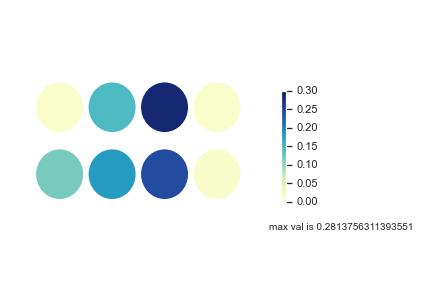

In [1291]:

nrow = 1 
ncol = 1
counter = 0
fig, axs = plt.subplots(nrow, ncol,figsize=(5, 5))

for ind, ax in enumerate(fig.axes):
    

    mask = poke_proportions_df.group == 'post'
    post_poke_proportions_df= poke_proportions_df[mask]


    ax.set_ylim([0, 5])
    ax.set_xlim([0, 5])

    colormap = plt.cm.get_cmap('YlGnBu') # 'plasma' or 'viridis'


    color_vals = [np.mean(post_poke_proportions_df.p1),np.mean(post_poke_proportions_df.p2),np.mean(post_poke_proportions_df.p3),np.mean(post_poke_proportions_df.p4),
                  np.mean(post_poke_proportions_df.p5),np.mean(post_poke_proportions_df.p6),np.mean(post_poke_proportions_df.p7),np.mean(post_poke_proportions_df.p8)]

    normalised_colour = np.array(color_vals)/0.3

    x = [1,2,3,4,1,2,3,4]
    y = [2,2,2,2,3.2,3.2,3.2,3.2]

    circles_ = []
    for i in range(8):
        color_ = colormap(normalised_colour[i])
        circles_ = circles_ + [plt.Circle((x[i], y[i]), 0.4,fill=True, linewidth=5, color = color_)]
    for i in range(8):
        ax.add_artist(circles_[i])

    plt.axis('off')
#     plt.text(0.7,1,('Port_Poke_proportions for Session '), horizontalalignment='left', size=20)





    # sc = plt.scatter(x, y, c=colors)

    sm = plt.cm.ScalarMappable(cmap=colormap)
    sm.set_clim(vmin=0, vmax=0.3)
    plt.text(5,1,('max val is '+ str(max(color_vals))),size=10)

    plt.colorbar(sm,fraction=0.02, pad=0.04)
    
    
SEM = [scipy.stats.sem(post_poke_proportions_df.p1),scipy.stats.sem(post_poke_proportions_df.p2),scipy.stats.sem(post_poke_proportions_df.p3),scipy.stats.sem(post_poke_proportions_df.p4),
              scipy.stats.sem(post_poke_proportions_df.p5),scipy.stats.sem(post_poke_proportions_df.p6),scipy.stats.sem(post_poke_proportions_df.p7),scipy.stats.sem(post_poke_proportions_df.p8)]

print('mean ratios per port: ' + str(np.array(color_vals)*100))
print('SEM per port: ' + str(np.array(SEM)*100))



#     poke_data = [poke_proportions_df.p1.values,poke_proportions_df.p2.values,poke_proportions_df.p3.values,poke_proportions_df.p4.values,
#                   poke_proportions_df.p5.values,poke_proportions_df.p6.values,poke_proportions_df.p7.values,poke_proportions_df.p8.values]

# SaveFig('poke_port_props.pdf',r'Z:\projects\Emmett\Documents\writeup\fig1_striatum_lesions\figs\\')

In [1062]:
l_error_rates_breakdown

,Animal,PreRepeat,PreMisseq,Preother,PostRepeat,PostMissseq,PostOther,pre_transition_types,pre_transition_times,post_transition_types,post_transition_times
0,EJT154,0.190694,0.137300,0.001373,0.422143,0.238571,0.004286,"[[16, 67, 73, 21, 44, 22, 26, 67, 77, 77, 77, ...","[[0.987099999999998, 1.6277000000000008, 0.412...","[[28, 87, 77, 77, 77, 77, 37, 77, 77, 73, 37, ...","[[1.0262000000000029, 0.6505999999999972, 0.01..."
0,EJT155,0.148672,0.085711,0.001968,0.220109,0.207322,0.005355,"[[11, 11, 12, 22, 23, 33, 37, 76, 66, 65, 12, ...","[[0.1126000000000004, 0.4693999999999931, 0.95...","[[12, 22, 23, 37, 73, 32, 21, 13, 33, 33, 37, ...","[[0.7670000000000003, 0.0001999999999995, 0.41..."
0,EJT156,0.199075,0.117385,0.002095,0.699822,0.154529,0.008881,"[[12, 26, 66, 66, 67, 63, 37, 77, 75, 56, 67, ...","[[1.2249999999999943, 0.5729999999999933, 1.79...","[[33, 77, 77, 73, 47, 77, 77, 77, 33, 37, 44, ...","[[0.4294999999999902, 0.1621000000000094, 0.83..."
0,EJT157,0.135377,0.128991,0.001916,0.298228,0.366076,0.012658,"[[88, 41, 23, 37, 76, 66, 67, 78, 84, 44, 44, ...","[[0.0067000000000092, 1.332800000000006, 0.478...","[[87, 27, 76, 61, 11, 21, 11, 16, 62, 22, 23, ...","[[0.4681000000000015, 0.8424999999999976, 0.98..."
0,EJT159,0.251421,0.193647,0.000801,0.366488,0.307100,0.003237,"[[23, 37, 78, 83, 37, 71, 13, 37, 76, 67, 73, ...","[[0.6437000000000097, 0.452699999999993, 1.323...","[[77, 37, 88, 63, 37, 33, 37, 72, 21, 16, 67, ...","[[0.0625, 0.5226000000000113, 0.14809999999999..."
0,EJT161,0.162704,0.092476,0.001002,0.544041,0.218653,0.024870,"[[66, 66, 66, 32, 21, 16, 66, 63, 37, 21, 13, ...","[[0.0840999999999994, 0.1423000000000058, 0.47...","[[44, 44, 44, 44, 44, 44, 44, 44, 47, 42, 26, ...","[[0.0080999999999988, 0.0001999999999995, 0.04..."
0,EJT85,0.320729,0.072939,0.001454,0.486496,0.191214,0.017645,"[[78, 23, 33, 77, 15, 56, 62, 22, 22, 22, 23, ...","[[0.6308000000000007, 1.3369, 0.11749999999999...","[[66, 66, 55, 77, 77, 87, 77, 77, 73, 36, 62, ...","[[0.5858000000000629, 0.0372999999999592, 0.05..."


In [1063]:
## merge across sessions for each animal - creates a list of transitions types (across sessions) for each animals 
Pre_TransitionTypes_flattened = []
Post_TransitionTypes_flattened = []
Pre_TransitionTimes_flattened = []
Post_TransitionTimes_flattened = []
for animal in l_error_rates_breakdown.Animal.values:
    mask = l_error_rates_breakdown.Animal.values == animal 
    Pre_TransitionTypes_flattened = Pre_TransitionTypes_flattened + [[item for sublist in list(l_error_rates_breakdown[mask].pre_transition_types[0]) for item in sublist] ]
    Post_TransitionTypes_flattened = Post_TransitionTypes_flattened + [[item for sublist in list(l_error_rates_breakdown[mask].post_transition_types[0]) for item in sublist] ]
    Pre_TransitionTimes_flattened = Pre_TransitionTimes_flattened + [[item for sublist in list(l_error_rates_breakdown[mask].pre_transition_times[0]) for item in sublist] ]
    Post_TransitionTimes_flattened = Post_TransitionTimes_flattened + [[item for sublist in list(l_error_rates_breakdown[mask].post_transition_times[0]) for item in sublist] ]

In [1231]:
pre_transition_means = []
pre_transition_std = []
for index, animal_ in enumerate(Pre_TransitionTypes_flattened):
    transitions = [21,16,63,37]
    transition_times = []
    for i,transit in enumerate(transitions):
        inds = np.where(np.array(animal_) == transit)
        transition_times = transition_times + list(np.array(Pre_TransitionTimes_flattened[index])[inds])
    pre_transition_means = pre_transition_means + [np.mean(transition_times)]
    pre_transition_std = pre_transition_std + [np.std(transition_times)]

post_transition_means = []
post_transition_std = []
for index, animal_ in enumerate(Post_TransitionTypes_flattened):
    transitions = [21,16,63,37]
    
    transition_times = []
    for i,transit in enumerate(transitions):
        inds = np.where(np.array(animal_) == transit)
        transition_times = transition_times + list(np.array(Post_TransitionTimes_flattened[index])[inds])

    post_transition_means = post_transition_means + [np.mean(transition_times)]
    post_transition_std = post_transition_std+ [np.std(transition_times)]

In [1239]:
pre_transition_means[i],post_transition_means[i]

(0.37426784605834806, 0.7221295221842988)

---- too few samples, assumed normal
Ttest_relResult(statistic=-3.6094112513359913, pvalue=0.01123887685706)


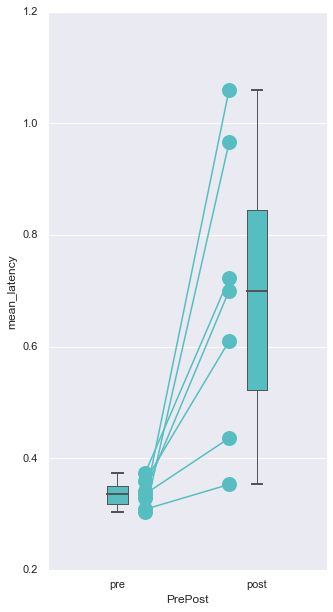

In [1276]:
#transition times

ort = 'v'

fig,ax = plt.subplots(1, 1, figsize=(5, 10))
for i in range(len(pre_transition_means)):
    ax.plot((0.2,0.8),(pre_transition_means[i],post_transition_means[i]),'o-',color ='#56BEC1',markeredgecolor = 'none',alpha = 1, markersize = 15,markeredgewidth=0)
#     ax.plot([*len(post_transition_means[i]),post_transition_means[i],'o',color ='#56BEC1',markeredgecolor = 'none',alpha = 1, markersize = 9,markeredgewidth=0)

    plot_df = pd.DataFrame({'PrePost':['pre']*len(pre_transition_means) + ['post']*len(post_transition_means) ,'mean_latency': pre_transition_means + post_transition_means})

    ax=sns.boxplot( x = 'PrePost', y = 'mean_latency', data = plot_df, color = '#56BEC1', width = .15, zorder = 10,\
    showcaps = True, boxprops = {'facecolor':'#56BEC1', "zorder":10,'linewidth':1},\
    showfliers=False, whiskerprops = {'linewidth':1, "zorder":10},\
       saturation = 1, orient = ort, ax = ax)

    
    ax.set_ylim([0.2, 1.2])
    
# print('post' + str(i))
# print(scipy.stats.normaltest(pre_transition_std))

# print('pre' + str(i))
# print(scipy.stats.normaltest(post_transition_std))

print('---- too few samples, assumed normal')

print(scipy.stats.ttest_rel(pre_transition_means,post_transition_means))

# SaveFig('transit_times.pdf',r'Z:\projects\Emmett\Documents\writeup\fig1_striatum_lesions\figs\\')

---- too few samples, assumed normal
Ttest_relResult(statistic=-4.219806142805741, pvalue=0.005562454813364773)


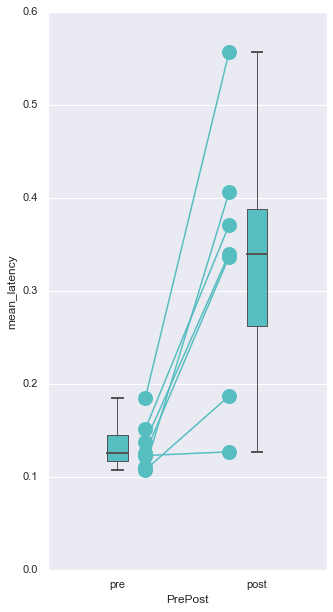

In [1277]:
#transition variability

ort = 'v'

fig,ax = plt.subplots(1, 1, figsize=(5, 10))
for i in range(len(pre_transition_std)):
    ax.plot((0.2,0.8),(pre_transition_std[i],post_transition_std[i]),'o-',color ='#56BEC1',markeredgecolor = 'none',alpha = 1, markersize = 15,markeredgewidth=0)
#     ax.plot([*len(post_transition_means[i]),post_transition_means[i],'o',color ='#56BEC1',markeredgecolor = 'none',alpha = 1, markersize = 9,markeredgewidth=0)

    plot_df = pd.DataFrame({'PrePost':['pre']*len(pre_transition_std) + ['post']*len(post_transition_std) ,'mean_latency': pre_transition_std + post_transition_std})

    ax=sns.boxplot( x = 'PrePost', y = 'mean_latency', data = plot_df, color = '#56BEC1', width = .15, zorder = 10,\
    showcaps = True, boxprops = {'facecolor':'#56BEC1', "zorder":10,'linewidth':1},\
    showfliers=False, whiskerprops = {'linewidth':1, "zorder":10},\
       saturation = 1, orient = ort, ax = ax)

    
    ax.set_ylim([0, 0.6])


# print('post' + str(i))
# print(scipy.stats.normaltest(pre_transition_std))

# print('pre' + str(i))
# print(scipy.stats.normaltest(post_transition_std))

print('---- too few samples, assumed normal')

print(scipy.stats.ttest_rel(pre_transition_std,post_transition_std))
    
# SaveFig('stand_dev.pdf',r'Z:\projects\Emmett\Documents\writeup\fig1_striatum_lesions\figs\\')

[0.1377056816460303,
 0.10740872093258433,
 0.18512054805401867,
 0.12590789238994077,
 0.12280746801503288,
 0.1101994482454245,
 0.1515611939472374]

---- too few samples, assumed normal
Ttest_relResult(statistic=-4.219806142805741, pvalue=0.005562454813364773)


In [1183]:
#stats
print('control stats:')
if scipy.stats.normaltest(list(plot_df.error_rate[cb_mask]) + list(plot_df.error_rate[cl_mask]))[-1] > 0.05:
    print('data is normally distributed')
else:
    print('data is not normally distributed')

print('---------')
#stats
print('lesion stats:')
if scipy.stats.normaltest(list(plot_df.error_rate[lb_mask]) + list(plot_df.error_rate[ll_mask]))[-1] > 0.05:
    print('data is normally distributed')
else:
    print('data is not normally distributed')
print(scipy.stats.ttest_rel(plot_df.error_rate[lb_mask],plot_df.error_rate[ll_mask]))

[[0.35086232798165684,
  0.3436998545454493,
  0.3083303405572728,
  0.38753608903020453,
  0.32443264604811506,
  0.27610806156101164,
  0.3248862385321136],
 [0.3297641961231388,
  0.34031336370539816,
  0.32298018867924017,
  0.40508142857143076,
  0.2986184107442605,
  0.34737168556902565,
  0.40709349794238153],
 [0.41165927189988605,
  0.35038035062088857,
  0.4512591871780209,
  0.3650503478260851,
  0.34183269230769076,
  0.3236958142576871,
  0.369380988274706],
 [0.29147098310956987,
  0.3118661764705868,
  0.2401584801207879,
  0.2982805725971386,
  0.2741720681265243,
  0.27376745579862344,
  0.39480685714285674]]

In [1181]:
t_code = ['T1']*len(pre_transition_means[0]) + ['T2']*len(pre_transition_means[1]) + ['T3']*len(pre_transition_means[2]) + ['T4']*len(pre_transition_means[3])
                                                                                                                                
plot_df1 = pd.DataFrame({'Transition':t_code,'Time':[item for sublist in pre_transition_means for item in sublist] })
#     plot_df= plot_df.append(tempt_df)

t_code = ['T1_']*len(post_transition_means[0]) + ['T2_']*len(post_transition_means[1]) + ['T3_']*len(post_transition_means[2]) + ['T4_']*len(post_transition_means[3])
                                                                                                                                
plot_df2 = pd.DataFrame({'Transition':t_code,'Time':[item for sublist in post_transition_means for item in sublist] })
#     plot_df= plot_df.append(tempt_df)

[Text(0, 0, 'Transition 1'),
 Text(1, 0, 'Transition 2'),
 Text(2, 0, 'Transition 3'),
 Text(3, 0, 'Transition 4')]

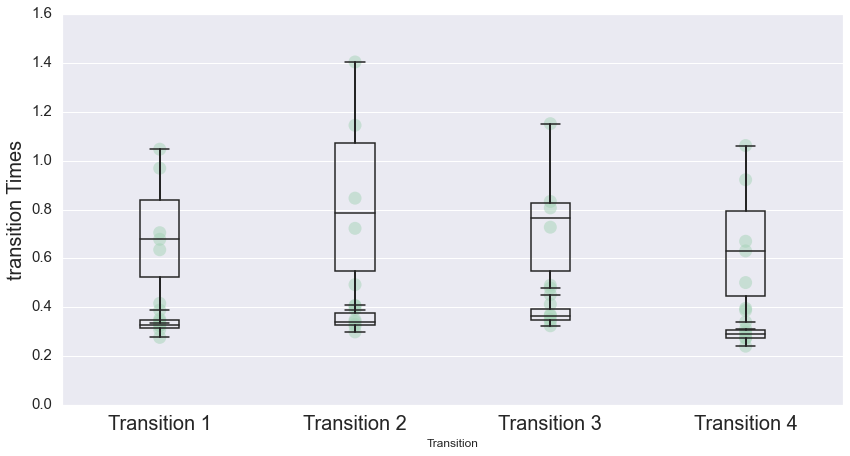

In [1182]:
fig,ax = plt.subplots(1, 1, figsize=(14, 7))

ax=sns.stripplot( y = 'Time', x = 'Transition', data = plot_df1, color = '#A5D3B7', edgecolor = "white",
                 size = 13, jitter = 0, zorder = 1, orient = 'v',ax = ax,alpha = 0.5)

ax=sns.boxplot (y = 'Time', x = 'Transition', data = plot_df1, color = dark_blue, width = .2, zorder = 10,\
            showcaps = True, boxprops = {'facecolor':'none', "zorder":10},\
            showfliers=False, whiskerprops = {'linewidth':2, "zorder":10},\
               saturation = 1, orient = 'v',ax = ax)

ax=sns.stripplot( y = 'Time', x = 'Transition', data = plot_df2, color = '#A5D3B7', edgecolor = "white",
                 size = 13, jitter = 0, zorder = 1, orient = 'v',ax = ax,alpha = 0.5)

ax=sns.boxplot (y = 'Time', x = 'Transition', data = plot_df2, color = dark_blue, width = .2, zorder = 10,\
            showcaps = True, boxprops = {'facecolor':'none', "zorder":10},\
            showfliers=False, whiskerprops = {'linewidth':2, "zorder":10},\
               saturation = 1, orient = 'v',ax = ax)

ax.set_ylabel('transition Times',size = 20)
ax.tick_params(axis="y", labelsize=15)
# ax.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False) 


ax.set_xticklabels(['Transition 1','Transition 2','Transition 3','Transition 4' ], fontsize = 20)

In [1157]:
t_code = ['T1']*len(post_transition_means[0]) + ['T2']*len(post_transition_means[1]) + ['T3']*len(post_transition_means[2]) + ['T4']*len(post_transition_means[3])
                                                                                                                                
plot_df = pd.DataFrame({'Transition':t_code,'Time':[item for sublist in post_transition_means for item in sublist] })
#     plot_df= plot_df.append(tempt_df)

[Text(0, 0, 'Transition 1'),
 Text(0, 1, 'Transition 2'),
 Text(0, 2, 'Transition 3'),
 Text(0, 3, 'Transition 4')]

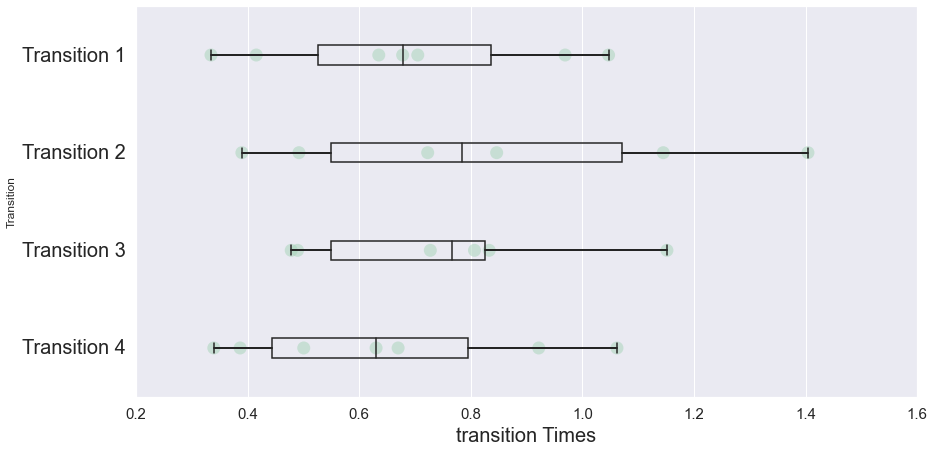

In [1158]:
fig,ax = plt.subplots(1, 1, figsize=(14, 7))

ax=sns.stripplot( x = 'Time', y = 'Transition', data = plot_df, color = '#A5D3B7', edgecolor = "white",
                 size = 13, jitter = 0, zorder = 1, orient = 'h',ax = ax,alpha = 0.5)

ax=sns.boxplot (x = 'Time', y = 'Transition', data = plot_df, color = dark_blue, width = .2, zorder = 10,\
            showcaps = True, boxprops = {'facecolor':'none', "zorder":10},\
            showfliers=False, whiskerprops = {'linewidth':2, "zorder":10},\
               saturation = 1, orient = 'h',ax = ax)

ax.set_xlabel('transition Times',size = 20)
ax.tick_params(axis="x", labelsize=15)
# ax.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False) 


ax.set_yticklabels(['Transition 1','Transition 2','Transition 3','Transition 4' ], fontsize = 20)

# SaveFig('Transition_times.svg',r'Z:\projects\Emmett\Documents\writeup\fig1_behaviour_figures\figs\\')


# #stats
# print(scipy.stats.normaltest(plot_df.Time[plot_df.Transition == 'T1']))
# print(scipy.stats.normaltest(plot_df.Time[plot_df.Transition == 'T2']))
# print(scipy.stats.normaltest(plot_df.Time[plot_df.Transition == 'T3']))
# print(scipy.stats.normaltest(plot_df.Time[plot_df.Transition == 'T4']))

# print('not all are normally distributed: Kruskal–Wallis used:')


# print(scipy.stats.kruskal(plot_df.Time[plot_df.Transition == 'T1'],plot_df.Time[plot_df.Transition == 'T2'],plot_df.Time[plot_df.Transition == 'T3'],plot_df.Time[plot_df.Transition == 'T4']))

# import scikit_posthocs as sp
# post_hoc_comp_dunn_test = sp.posthoc_dunn([plot_df.Time[plot_df.Transition == 'T1'],plot_df.Time[plot_df.Transition == 'T2'],plot_df.Time[plot_df.Transition == 'T3'],plot_df.Time[plot_df.Transition == 'T4']], p_adjust = 'bonferroni')
# print(post_hoc_comp_dunn_test)

In [1159]:
pre_transition_std


[[0.1248142034666355,
  0.13101909634573383,
  0.14322446665026692,
  0.14385594085143397,
  0.17442424508449567,
  0.13422135024686252,
  0.10262056235941035],
 [0.14627789139749794,
  0.09127422624826814,
  0.06882266819483074,
  0.15041723770219737,
  0.08577801246622911,
  0.11688692808769179,
  0.1238239145966303],
 [0.14102210431121479,
  0.09823654373763557,
  0.26940517142051945,
  0.09569208315289064,
  0.12990060592708436,
  0.09094175348334871,
  0.18040439363155059],
 [0.1120057117732994,
  0.10034044144906151,
  0.1309214379359946,
  0.07854482399991276,
  0.06864730557622949,
  0.07988740294218007,
  0.17172470717698501]]

[Text(0, 0, 'Transition 1'),
 Text(0, 1, 'Transition 2'),
 Text(0, 2, 'Transition 3'),
 Text(0, 3, 'Transition 4')]

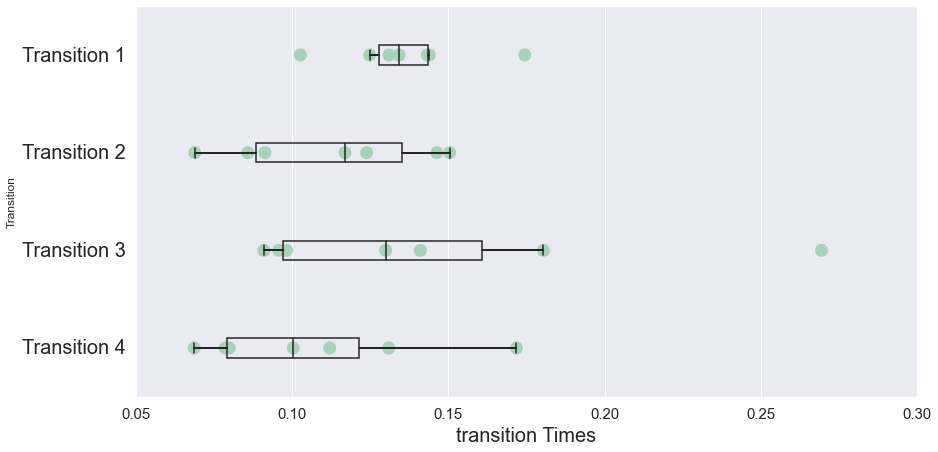

In [1165]:
t_code = ['T1']*len(pre_transition_std[0]) + ['T2']*len(pre_transition_std[1]) + ['T3']*len(pre_transition_std[2]) + ['T4']*len(pre_transition_std[3])
                                                                                                                                
plot_df = pd.DataFrame({'Transition':t_code,'Time':[item for sublist in pre_transition_std for item in sublist] })
#     plot_df= plot_df.append(tempt_df)

fig,ax = plt.subplots(1, 1, figsize=(14, 7))

ax=sns.stripplot( x = 'Time', y = 'Transition', data = plot_df, color = '#A5D3B7', edgecolor = "white",
                 size = 13, jitter = 0, zorder = 1, orient = 'h',ax = ax,alpha = 1)

ax=sns.boxplot (x = 'Time', y = 'Transition', data = plot_df, color = dark_blue, width = .2, zorder = 10,\
            showcaps = True, boxprops = {'facecolor':'none', "zorder":10},\
            showfliers=False, whiskerprops = {'linewidth':2, "zorder":10},\
               saturation = 1, orient = 'h',ax = ax)

ax.set_xlabel('transition Times',size = 20)
ax.tick_params(axis="x", labelsize=15)
# ax.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False) 


ax.set_yticklabels(['Transition 1','Transition 2','Transition 3','Transition 4' ], fontsize = 20)

In [1169]:
t_code = ['T1']*len(post_transition_std[0]) + ['T2']*len(post_transition_std[1]) + ['T3']*len(post_transition_std[2]) + ['T4']*len(post_transition_std[3])
                                                                                                                                
plot_df = pd.DataFrame({'Transition':t_code,'Time':[item for sublist in post_transition_std for item in sublist] })
#     plot_df= plot_df.append(tempt_df)

[Text(0, 0, 'Transition 1'),
 Text(0, 1, 'Transition 2'),
 Text(0, 2, 'Transition 3'),
 Text(0, 3, 'Transition 4')]

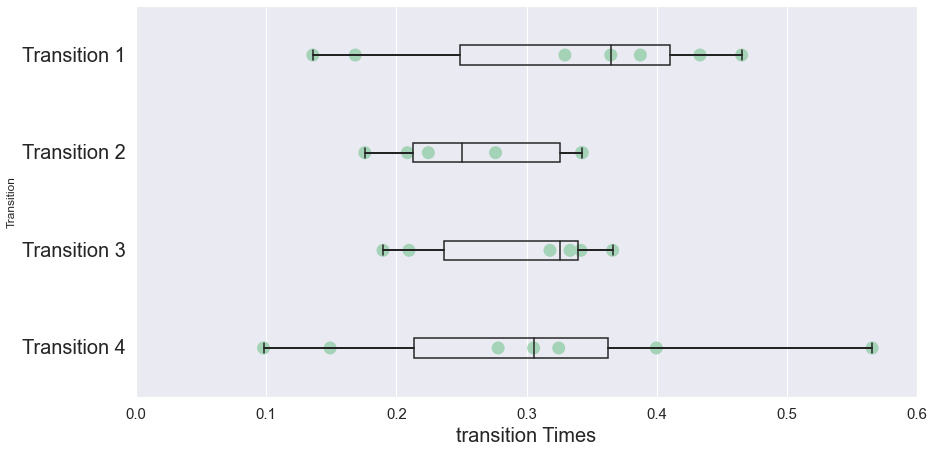

In [1170]:
fig,ax = plt.subplots(1, 1, figsize=(14, 7))

ax=sns.stripplot( x = 'Time', y = 'Transition', data = plot_df, color = '#A5D3B7', edgecolor = "white",
                 size = 13, jitter = 0, zorder = 1, orient = 'h',ax = ax,alpha = 1)

ax=sns.boxplot (x = 'Time', y = 'Transition', data = plot_df, color = dark_blue, width = .2, zorder = 10,\
            showcaps = True, boxprops = {'facecolor':'none', "zorder":10},\
            showfliers=False, whiskerprops = {'linewidth':2, "zorder":10},\
               saturation = 1, orient = 'h',ax = ax)



ax.set_xlabel('transition Times',size = 20)
ax.tick_params(axis="x", labelsize=15)
# ax.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False) 


ax.set_yticklabels(['Transition 1','Transition 2','Transition 3','Transition 4' ], fontsize = 20)

In [1040]:
poke_proportions_df

,animal,group,p1,p2,p3,p4,p5,p6,p7,p8
0,EJT85,post,0.11879,0.156228,0.195464,0.018719,0.039597,0.138589,0.315695,0.016919


In [976]:
AA_port_proportions_pre

[]

In [975]:
poke_proportions_df

,animal,p1,p2,p3,p4,p5,p6,p7,p8
0,EJT101,0.181225,0.2098,0.230607,0.002014,0.0,0.226388,0.147665,0.002301
1,EJT147,0.181225,0.2098,0.230607,0.002014,0.0,0.226388,0.147665,0.002301
2,EJT148,0.181225,0.2098,0.230607,0.002014,0.0,0.226388,0.147665,0.002301
3,EJT174,0.181225,0.2098,0.230607,0.002014,0.0,0.226388,0.147665,0.002301
4,EJT175,0.181225,0.2098,0.230607,0.002014,0.0,0.226388,0.147665,0.002301
5,EJT176,0.181225,0.2098,0.230607,0.002014,0.0,0.226388,0.147665,0.002301
6,EJT177,0.181225,0.2098,0.230607,0.002014,0.0,0.226388,0.147665,0.002301
7,EJT99,0.181225,0.2098,0.230607,0.002014,0.0,0.226388,0.147665,0.002301


In [344]:
AA_port_proportions= []

for animal in range(len(data.animal.values)):
    ports= []
    for session in np.unique(data.trials_4000to5000_session[animal]):
        session_mask = np.array(data.trials_4000to5000_session[animal]) == session


[33,
 31,
 11,
 42,
 22,
 11,
 11,
 16,
 22,
 22,
 26,
 74,
 83,
 21,
 11,
 11,
 16,
 66,
 63,
 33,
 37,
 44,
 88,
 88,
 17,
 73,
 33,
 33,
 26,
 63,
 37,
 43,
 33,
 11,
 32,
 26,
 67,
 77,
 76,
 63,
 33,
 37,
 48,
 11,
 63,
 33,
 37,
 37,
 77,
 31,
 16,
 66,
 66,
 37,
 72,
 21,
 16,
 66,
 66,
 63,
 37,
 72,
 21,
 16,
 66,
 66,
 11,
 11,
 66,
 66,
 62,
 21,
 11,
 16,
 66,
 37,
 16,
 62,
 22,
 26,
 63,
 37,
 77,
 22,
 21,
 16,
 63,
 37,
 77,
 23,
 37,
 77,
 77,
 72,
 26,
 66,
 66,
 66,
 66,
 61,
 16,
 63,
 37,
 72,
 21,
 16,
 63,
 37,
 72,
 21,
 11,
 11,
 16,
 63,
 33,
 37,
 72,
 21,
 16,
 63,
 33,
 37,
 72,
 21,
 16,
 63,
 33,
 37,
 72,
 21,
 16,
 63,
 33,
 37,
 77,
 76,
 61,
 34,
 12,
 23,
 32,
 21,
 16,
 63,
 33,
 37,
 72,
 21,
 16,
 66,
 61,
 16,
 66,
 62,
 21,
 84,
 21,
 16,
 63,
 37,
 72,
 21,
 11,
 12,
 21,
 16,
 66,
 63,
 37,
 77,
 21,
 11,
 16,
 63,
 37,
 77,
 21,
 16,
 66,
 63,
 37,
 77,
 77,
 21,
 16,
 66,
 66,
 63,
 37,
 72,
 21,
 16,
 66,
 63,
 33,
 37,
 73,
 33,
 32,
 21,


In [312]:
## for each session pull out all the first ports that was entered, for the last transiton also take the second one as it wont appear in a subsequent transition
AA_port_proportions= []

for animal in range(len(data.animal.values)):
    ports= []
    for session in np.unique(data.trials_4000to5000_session[animal]):
        session_mask = np.array(data.trials_4000to5000_session[animal]) == session
        for index, transit in enumerate(np.array(data.trials_4000to5000_transitions[animal])[session_mask]):
            ports = ports + [int(str(transit)[0])]
            if index == len(np.array(data.trials_4000to5000_transitions[animal])[session_mask])-1:
                ports = ports + [int(str(transit)[-1])]

    port_proportions=[data.animal.values[animal]]
    for i in range(1,9):
        port_proportions = port_proportions + [sum(np.array(ports) == i)/len(ports)]

    AA_port_proportions = AA_port_proportions + [port_proportions]

poke_proportions_df = pd.DataFrame(AA_port_proportions, columns = ['animal','p1','p2','p3','p4','p5','p6','p7','p8'])


fig,ax = plt.subplots(1, 1, figsize=(20, 20))
ax.set_ylim([0, 5])
ax.set_xlim([0, 5])

colormap = plt.cm.get_cmap('viridis') # 'plasma' or 'viridis'


color_vals = [np.mean(poke_proportions_df.p1),np.mean(poke_proportions_df.p2),np.mean(poke_proportions_df.p3),np.mean(poke_proportions_df.p4),
              np.mean(poke_proportions_df.p5),np.mean(poke_proportions_df.p6),np.mean(poke_proportions_df.p7),np.mean(poke_proportions_df.p8)]

normalised_colour = np.array(color_vals)/max(color_vals)

x = [1,2,3,4,1,2,3,4]
y = [2,2,2,2,3.2,3.2,3.2,3.2]

circles_ = []
for i in range(8):
    color_ = colormap(normalised_colour[i])
    circles_ = circles_ + [plt.Circle((x[i], y[i]), 0.4,fill=True, linewidth=5, color = color_)]
for i in range(8):
    ax.add_artist(circles_[i])

plt.axis('off')
plt.text(0.7,1,('Port_Poke_proportions for Session '), horizontalalignment='left', size=20)


# sc = plt.scatter(x, y, c=colors)

sm = plt.cm.ScalarMappable(cmap=colormap)
sm.set_clim(vmin=0, vmax=max(color_vals))
plt.text(5,1,('max val is '+ str(max(color_vals))),size=10)

plt.colorbar(sm,fraction=0.02, pad=0.04)


poke_data = [poke_proportions_df.p1.values,poke_proportions_df.p2.values,poke_proportions_df.p3.values,poke_proportions_df.p4.values,
              poke_proportions_df.p5.values,poke_proportions_df.p6.values,poke_proportions_df.p7.values,poke_proportions_df.p8.values]

nrow = 2 
ncol = 4
fig, axs = plt.subplots(nrow, ncol,figsize=(20, 5))

for ind, ax in enumerate(fig.axes):

    ax.plot(poke_data[ind],np.zeros(len(animals)),'o',alpha = 0.4, color = dark_blue,markersize = 10)
    ax.plot(color_vals[ind],0,'|',color = dark_pink,markersize = 40, markeredgewidth = 5)
    ax.set_xlim([0, np.max(poke_data)])
    
    ax.set_title('Port ' + str(ind + 1), size=20)

# SaveFig('PokeProportions.svg',r'Z:\projects\Emmett\Documents\writeup\fig1_behaviour_figures\figs\\')


[[0.6308000000000007,
  1.3369,
  0.1174999999999997,
  0.4589999999999961,
  1.9557000000000075,
  0.639899999999983,
  0.981099999999998,
  0.0002000000000066,
  0.0165000000000077,
  0.1238999999999919,
  0.8620999999999981,
  0.9087000000000104,
  0.0475999999999885,
  0.7749999999999773,
  0.1852000000000089,
  0.45739999999995,
  0.651800000000037,
  0.5407000000000153,
  0.9950999999999794,
  0.3980999999999994,
  0.6595000000000368,
  0.3908999999999878,
  1.9601999999999864,
  0.708500000000015,
  0.6105000000000018,
  0.7602999999999724,
  0.6808000000000334,
  0.6528000000000134,
  0.3421999999999912,
  0.055499999999995,
  0.1265999999999962,
  0.1622000000000412,
  0.2349999999999568,
  1.4524999999999864,
  0.6875,
  0.4507999999999583,
  1.3038000000000238,
  0.3777000000000043,
  1.125,
  0.5796000000000276,
  1.2099000000000046,
  0.9821000000000026,
  0.7788999999999646,
  1.3894999999999982,
  0.9207000000000108,
  0.2305999999999812,
  0.7037000000000262,
  1.842199

In [295]:
repeats = list(l_error_rates_breakdown.PreRepeat.values) + list(l_error_rates_breakdown.PostRepeat.values)
inds = [0]*len(l_error_rates_breakdown.Animal.values) + [1]*len(l_error_rates_breakdown.Animal.values)
repeat_errors_df = pd.DataFrame({ 'PrePost':inds, 'error_rate':  repeats })

Misseq = list(l_error_rates_breakdown.PreMisseq.values) + list(l_error_rates_breakdown.PostMissseq.values)
inds = [0]*len(l_error_rates_breakdown.Animal.values) + [1]*len(l_error_rates_breakdown.Animal.values)
Misseq_errors_df = pd.DataFrame({ 'PrePost':inds, 'error_rate':  Misseq })

Other = list(l_error_rates_breakdown.Preother.values) + list(l_error_rates_breakdown.PostOther.values)
inds = [0]*len(l_error_rates_breakdown.Animal.values) + [1]*len(l_error_rates_breakdown.Animal.values)
Other_errors_df = pd.DataFrame({ 'PrePost':inds, 'error_rate':  Other })

only 7 data values per gorup - too few for normality test. data assumed normal
Ttest_relResult(statistic=-3.9853480248390887, pvalue=0.007238908484351173)
---------
Ttest_relResult(statistic=-5.465217472927817, pvalue=0.001564905666260534)
---------
RanksumsResult(statistic=-3.1304951684997055, pvalue=0.001745118699528905)


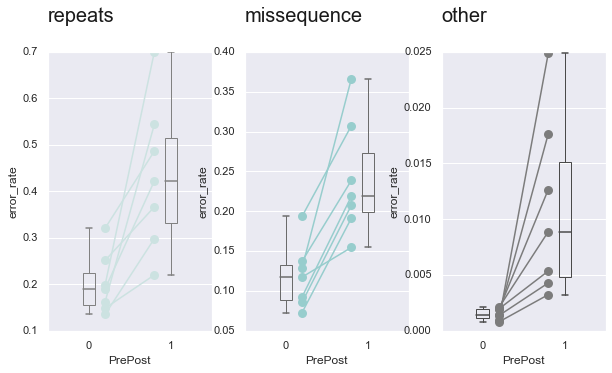

In [733]:
# plt.style.use('default') 

type_split_data = dict(tuple(repeat_errors_df.groupby('PrePost')))
PreRepeats = list(type_split_data[0]['error_rate'])
PostRepeats = list(type_split_data[1]['error_rate'])

type_split_data = dict(tuple(Misseq_errors_df.groupby('PrePost')))
PreMisseq = list(type_split_data[0]['error_rate'])
PostMisseq = list(type_split_data[1]['error_rate'])

type_split_data = dict(tuple(Other_errors_df.groupby('PrePost')))
PreOther = list(type_split_data[0]['error_rate'])
PostOther = list(type_split_data[1]['error_rate'])

titles = ['repeats', 'missequence','other']

ort = 'v'

fig,axs = plt.subplots(1, 3, figsize=(10, 5))
for ind, ax in enumerate(fig.axes):
            
    if ind == 0:
        for i in range(len(PostRepeats)):
            ax.plot([0.2,0.8],[PreRepeats[i],PostRepeats[i]],'o-',color ='#CCE2E1',markeredgecolor = 'none',alpha = 1, markersize = 9,markeredgewidth=0)
            
        ax=sns.boxplot( x = 'PrePost', y = 'error_rate', data = repeat_errors_df, color = '#CCE2E1', width = .15, zorder = 10,\
            showcaps = True, boxprops = {'facecolor':'none', "zorder":10,'linewidth':1},\
            showfliers=False, whiskerprops = {'linewidth':1, "zorder":10},\
               saturation = 1, orient = ort, ax = ax)
        
            
    if ind == 1:
        for i in range(len(PreMisseq)):
            ax.plot([0.2,0.8],[PreMisseq[i],PostMisseq[i]],'o-',color ='#97CDCD',markeredgecolor = 'none',alpha = 1, markersize = 9,markeredgewidth=0)

        ax=sns.boxplot( x = 'PrePost', y = 'error_rate', data = Misseq_errors_df, color = '#97CDCD', width = .15, zorder = 10,\
            showcaps = True, boxprops = {'facecolor':'none', "zorder":10,'linewidth':1},\
            showfliers=False, whiskerprops = {'linewidth':1, "zorder":10},\
               saturation = 1, orient = ort, ax = ax)
        
            
    if ind == 2:
        for i in range(len(PreOther)):
            ax.plot([0.2,0.8],[PreOther[i],PostOther[i]],'o-',color ='#7C7C7C',markeredgecolor = 'none',alpha = 1, markersize = 9,markeredgewidth=0)

        ax=sns.boxplot( x = 'PrePost', y = 'error_rate', data = Other_errors_df, color = '#7C7C7C', width = .15, zorder = 10,\
                showcaps = True, boxprops = {'facecolor':'none', "zorder":10,'linewidth':1},\
                showfliers=False, whiskerprops = {'linewidth':1, "zorder":10},\
                   saturation = 1, orient = ort, ax = ax)
        

    ax.set_xlim([-0.5, 1.5])
    
#     ax.axis('off')
    
    ax.set_title(titles[ind], loc = 'left',fontsize = 20,pad = 30, color = 'k')
    
    
#stats
print('only 7 data values per gorup - too few for normality test. data assumed normal')
# print('repeat stats:')
# if scipy.stats.normaltest(repeat_errors_df.error_rate.values)[-1] > 0.05:
#     print('data is normally distributed')
# else:
#     print('data is not normally distributed')
print(scipy.stats.ttest_rel(repeat_errors_df.error_rate[repeat_errors_df.PrePost == 0],repeat_errors_df.error_rate[repeat_errors_df.PrePost == 1]))

print('---------')
# print('misseq stats:')
# if scipy.stats.normaltest(Misseq_errors_df.error_rate.values)[-1] > 0.05:
#     print('data is normally distributed')
# else:
#     print('data is not normally distributed')
print(scipy.stats.ttest_rel(Misseq_errors_df.error_rate[Misseq_errors_df.PrePost == 0],Misseq_errors_df.error_rate[Misseq_errors_df.PrePost == 1]))

print('---------')
# print('other stats:')
# if scipy.stats.normaltest(Other_errors_df.error_rate.values)[-1] > 0.05:
#     print('data is normally distributed')
# else:
#     print('data is not normally distributed')
print(scipy.stats.ranksums(Other_errors_df.error_rate[Other_errors_df.PrePost == 0],Other_errors_df.error_rate[Other_errors_df.PrePost == 1]))

    
# SaveFig('error_rate_breakdown.svg',r'Z:\projects\Emmett\Documents\writeup\fig1_striatum_lesions\figs\\')

In [974]:
stats.ttest_rel(Misseq_errors_df.error_rate[Misseq_errors_df.PrePost == 0],Misseq_errors_df.error_rate[Misseq_errors_df.PrePost == 1])



scipy.stats.ttest_ind(Misseq_errors_df.error_rate[Misseq_errors_df.PrePost == 0],Misseq_errors_df.error_rate[Misseq_errors_df.PrePost == 1])
scipy.stats.ttest_ind(Misseq_errors_df.error_rate[Misseq_errors_df.PrePost == 0],Misseq_errors_df.error_rate[Misseq_errors_df.PrePost == 1])
scipy.stats.ttest_ind(Misseq_errors_df.error_rate[Misseq_errors_df.PrePost == 0],Misseq_errors_df.error_rate[Misseq_errors_df.PrePost == 1])

NameError: name 'stats' is not defined

repeat pre-proportion = 0.6267087778116783   SEM = 0.024639369023963825
misseq pre-proportion = 0.3685716632252995   SEM = 0.015383856281761865
other pre-proportion = 0.004719558963022132   SEM = 0.00018884421037004302
-----------------
repeat post-proportion = 0.6330765754936911   SEM = 0.060633209289781
misseq post-proportion = 0.35088814845435023   SEM = 0.02743248747574698
other post-proportion = 0.016035276051958612   SEM = 0.003011837274520427


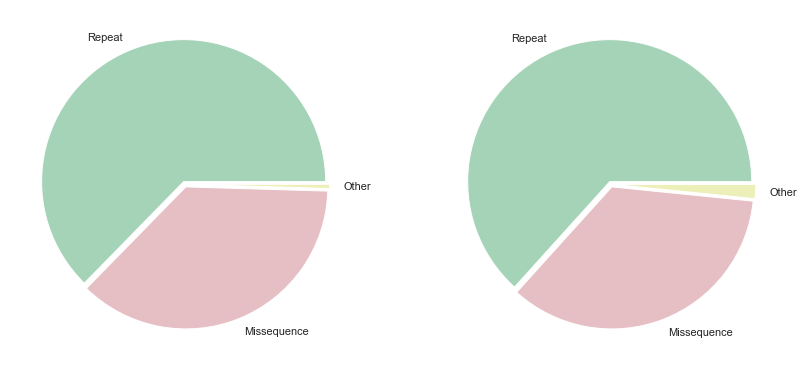

In [972]:
fig,[ax,ax1] = plt.subplots(1, 2, figsize=(14, 8))

explode = (0.02, 0.02, 0.02)
colors = ['#A5D3B7','#E6BFC4','#ECEFB7']

prerepeat_mean = np.mean(l_error_rates_breakdown.PreRepeat.values)
premisseq_mean = np.mean(l_error_rates_breakdown.PreMisseq.values)
preother_mean= np.mean(l_error_rates_breakdown.Preother.values)
total_prop = prerepeat_mean + premisseq_mean + preother_mean

y = np.array([prerepeat_mean/total_prop, premisseq_mean/total_prop,preother_mean/total_prop])
mylabels = ["Repeat", "Missequence", "Other" ]

ax.pie(y, labels = mylabels,explode =explode, colors=colors )

Postrepeat_mean = np.mean(l_error_rates_breakdown.PostRepeat.values)
Postmisseq_mean = np.mean(l_error_rates_breakdown.PostMissseq.values)
Postother_mean= np.mean(l_error_rates_breakdown.PostOther.values)
total_prop = Postrepeat_mean + Postmisseq_mean + Postother_mean

y2 = np.array([Postrepeat_mean/total_prop, Postmisseq_mean/total_prop,Postother_mean/total_prop])
mylabels = ["Repeat", "Missequence", "Other" ]

ax1.pie(y2, labels = mylabels,explode =explode,colors=colors )

prerepeat_sem = scipy.stats.sem(l_error_rates_breakdown.PreRepeat.values)
premisseq_sem = scipy.stats.sem(l_error_rates_breakdown.PreMisseq.values)
preother_sem= scipy.stats.sem(l_error_rates_breakdown.Preother.values)
Postrepeat_sem = scipy.stats.sem(l_error_rates_breakdown.PostRepeat.values)
Postmisseq_sem = scipy.stats.sem(l_error_rates_breakdown.PostMissseq.values)
Postother_sem= scipy.stats.sem(l_error_rates_breakdown.PostOther.values)

print('repeat pre-proportion = ' + str(y[0]) + '   SEM = ' + str(prerepeat_sem))
print('misseq pre-proportion = ' + str(y[1]) + '   SEM = ' + str(premisseq_sem))
print('other pre-proportion = ' + str(y[2]) + '   SEM = ' + str(preother_sem))
print('-----------------')
print('repeat post-proportion = ' + str(y2[0]) + '   SEM = ' + str(Postrepeat_sem))
print('misseq post-proportion = ' + str(y2[1]) + '   SEM = ' + str(Postmisseq_sem))
print('other post-proportion = ' + str(y2[2]) + '   SEM = ' + str(Postother_sem))
      
    
# SaveFig('error_rate_proportions.svg',r'Z:\projects\Emmett\Documents\writeup\fig1_striatum_lesions\figs\\')

In [ ]:
## transition speed 
## poke proportions


In [973]:

def extract_errorBreakdown_into_df(input_):

    seq_errors = []
    spa_errors = []
    rep_errors = []
    oth_errors = []

    for i in range (3):
        for e in range(4):
            if e == 0:
                seq_errors = seq_errors + [list(np.array(input_[i])[:,e])]
            if e == 1:
                spa_errors = spa_errors + [list(np.array(input_[i])[:,e])]
            if e == 2:
                rep_errors = rep_errors + [list(np.array(input_[i])[:,e])]
            if e == 3:
                oth_errors = oth_errors + [list(np.array(input_[i])[:,e])]

    errors = pd.DataFrame({ 'Group':['Early','Pre', 'Post'], 'seq_errors':  seq_errors, 
        'spa_errors': spa_errors, 'rep_errors': rep_errors, 'oth_errors': oth_errors })
    return errors 


c_errorsbd = extract_errorBreakdown_into_df(control_df['AA_errorbreakdown'])
l_errorsbd = extract_errorBreakdown_into_df(lesion_df['AA_errorbreakdown'])


buzz_words = 'seq_errors', 'spa_errors', 'rep_errors', 'oth_errors'

nrow = 1 
ncol = 4
counter = 0
fig, axs = plt.subplots(nrow, ncol,figsize=(40, 20))
for i, ax in enumerate(fig.axes):

    buzz =buzz_words[i]

    ax.set_title(buzz,loc = 'left',fontsize = 20,pad = 5)

    
#     for i in range(len(Controls)):
#         plt.plot([0,1],[c_errorsbd[buzz][1][i],c_errorsbd[buzz][2][i]],'o-')
#     for i in range(len(Lesions)):
#         plt.plot([2,3],[l_errorsbd[buzz][1][i],l_errorsbd[buzz][2][i]],'o-')

    for i in range(len(Controls)):
        ax.plot([0,1],[c_errorsbd[buzz][1][i],c_errorsbd[buzz][2][i]],'o-',color = colors[1],alpha = 0.5, markersize = 15)
    for i in range(len(Lesions)):
        ax.plot([2,3],[l_errorsbd[buzz][1][i],l_errorsbd[buzz][2][i]],'o-',color = colors[0],alpha = 0.5, markersize = 15)

    ax.bar(0,np.mean(np.mean(c_errorsbd[buzz][1])),color = colors[1], alpha = 0.4)
    ax.bar(1,np.mean(np.mean(c_errorsbd[buzz][2])),color = colors[1], alpha = 0.4)

    ax.bar(2,np.mean(np.mean(l_errorsbd[buzz][1])),color = colors[0], alpha = 0.4)
    ax.bar(3,np.mean(np.mean(l_errorsbd[buzz][2])),color = colors[0], alpha = 0.4)

    ax.set_ylim([0, 1])

    ax.set_xticks([0,1,2,3])
    ax.set_xticklabels(('Baseline', 'Saline', 'Baseline', 'Lesion'), fontsize = 15)

    ax.set_ylabel('Error proportions',fontsize = 30)

    ax.tick_params(axis='both', which='major', labelsize=30)

NameError: name 'control_df' is not defined

In [477]:
l_error_rates_breakdown

,Animal,PreRepeat,PreMisseq,Preother,PostRepeat,PostMissseq,PostOther,pre_transition_types,pre_transition_times,post_transition_types,post_transition_times
0,EJT154,0.190694,0.137300,0.001373,0.422143,0.238571,0.004286,"[[16, 67, 73, 21, 44, 22, 26, 67, 77, 77, 77, ...","[[0.987099999999998, 1.6277000000000008, 0.412...","[[28, 87, 77, 77, 77, 77, 37, 77, 77, 73, 37, ...","[[1.0262000000000029, 0.6505999999999972, 0.01..."
0,EJT155,0.148672,0.085711,0.001968,0.220109,0.207322,0.005355,"[[11, 11, 12, 22, 23, 33, 37, 76, 66, 65, 12, ...","[[0.1126000000000004, 0.4693999999999931, 0.95...","[[12, 22, 23, 37, 73, 32, 21, 13, 33, 33, 37, ...","[[0.7670000000000003, 0.0001999999999995, 0.41..."
0,EJT156,0.199075,0.117385,0.002095,0.699822,0.154529,0.008881,"[[12, 26, 66, 66, 67, 63, 37, 77, 75, 56, 67, ...","[[1.2249999999999943, 0.5729999999999933, 1.79...","[[33, 77, 77, 73, 47, 77, 77, 77, 33, 37, 44, ...","[[0.4294999999999902, 0.1621000000000094, 0.83..."
0,EJT157,0.135377,0.128991,0.001916,0.298228,0.366076,0.012658,"[[88, 41, 23, 37, 76, 66, 67, 78, 84, 44, 44, ...","[[0.0067000000000092, 1.332800000000006, 0.478...","[[87, 27, 76, 61, 11, 21, 11, 16, 62, 22, 23, ...","[[0.4681000000000015, 0.8424999999999976, 0.98..."
0,EJT159,0.251421,0.193647,0.000801,0.366488,0.307100,0.003237,"[[23, 37, 78, 83, 37, 71, 13, 37, 76, 67, 73, ...","[[0.6437000000000097, 0.452699999999993, 1.323...","[[77, 37, 88, 63, 37, 33, 37, 72, 21, 16, 67, ...","[[0.0625, 0.5226000000000113, 0.14809999999999..."
0,EJT161,0.162704,0.092476,0.001002,0.544041,0.218653,0.024870,"[[66, 66, 66, 32, 21, 16, 66, 63, 37, 21, 13, ...","[[0.0840999999999994, 0.1423000000000058, 0.47...","[[44, 44, 44, 44, 44, 44, 44, 44, 47, 42, 26, ...","[[0.0080999999999988, 0.0001999999999995, 0.04..."
0,EJT85,0.320729,0.072939,0.001454,0.486496,0.191214,0.017645,"[[78, 23, 33, 77, 15, 56, 62, 22, 22, 22, 23, ...","[[0.6308000000000007, 1.3369, 0.11749999999999...","[[66, 66, 55, 77, 77, 87, 77, 77, 73, 36, 62, ...","[[0.5858000000000629, 0.0372999999999592, 0.05..."


In [247]:
from datetime import datetime

def days_between(d1, d2):
    d1 = datetime.strptime(d1, "%Y%m%d")
    d2 = datetime.strptime(d2, "%Y%m%d")
    return abs((d2 - d1).days)

In [253]:
def load_transitions_for_file_catagory(files,InputPathCurrent,Tlevel_filter):

    # transition times
    TransitionTypes = []
    TransitionTimes = []
    Transitions = []
    # transitions
    TimeFiltered_seqs = []
    Sessions_processed = []

    for index, file in enumerate(files):

        CurrentInputPath = (InputPathCurrent +file+'\\')

        with open (CurrentInputPath+'Preprocessed_TrainingLevels' , 'rb') as fp:
            TrainingLevels = list(pickle.load(fp))

        # if every trial was at level 50:
        if Tlevel_filter == False:
            process_data = True
        elif all_50(TrainingLevels):
            process_data = True
        else:
            process_data = False
            
        if process_data == True:
            
            Sessions_processed = Sessions_processed + [int(file[0:2])]

            print(file)
            Session_data =  pd.read_csv((CurrentInputPath+'PreProcessed_SessionInfo.csv'))
            poke_data =  pd.read_csv((CurrentInputPath+'PreProcessed_RawPokeData.csv'))
            transition_data =  pd.read_csv((CurrentInputPath+'PreProcessed_TransitionData.csv'))
            timefiltseqs_data =  pd.read_csv((CurrentInputPath+'PreProcessed_Sequence_timefilteredonly_df.csv'))
            P1alignedtimefiltseqs_data =  pd.read_csv((CurrentInputPath+'PreProcessed_Sequence_df_timefiltered_port1aligned.csv'))
            P2alignedtimefiltseqs_data =  pd.read_csv((CurrentInputPath+'PreProcessed_Sequence_df_timefiltered_port2aligned.csv'))
            P3alignedtimefiltseqs_data =  pd.read_csv((CurrentInputPath+'PreProcessed_Sequence_df_timefiltered_port3aligned.csv'))
            P4alignedtimefiltseqs_data =  pd.read_csv((CurrentInputPath+'PreProcessed_Sequence_df_timefiltered_port4aligned.csv'))
            P5alignedtimefiltseqs_data =  pd.read_csv((CurrentInputPath+'PreProcessed_Sequence_df_timefiltered_port5aligned.csv'))


            #pull data out:

            ## transition times
            TransitionTypes_Tfilt,TransitionLatency_Tfilt = transition_time_data(transition_data)
            TransitionTypes = TransitionTypes + [TransitionTypes_Tfilt]
            TransitionTimes = TransitionTimes + [TransitionLatency_Tfilt]
            if index == 0:
                Transitions = Define_Transitions(Session_data)

            # transitions
            TimeFiltered_seqs = TimeFiltered_seqs + [list(timefiltseqs_data.loc[:,'Sequence_ids'])]

    return(TransitionTypes,TransitionTimes,Transitions,TimeFiltered_seqs,Sessions_processed)

In [263]:
def transition_time_data(transition_data):   
    #pull data from dfs:
    Time_filter = np.array(transition_data.loc[:,'2s_Time_Filter_in_in'])
    TransitionTypes_unfilt = np.array(transition_data.loc[:,'Transition_type'])
    TransitionLatency_unfilt = np.array(transition_data.loc[:,'in_in_Latency'])
    # filter out transitions that are too slow (defined in preprocessing as 2s)
    TransitionTypes_Tfilt = list(TransitionTypes_unfilt[Time_filter==1])
    TransitionLatency_Tfilt = list(TransitionLatency_unfilt[Time_filter==1])
    return (TransitionTypes_Tfilt,TransitionLatency_Tfilt) 

def Define_Transitions(Session_data):
    # determine ports for each transition 
    Transitions = []
    Transitions = Transitions + list(np.array(Session_data.loc[:,'Transition1']))
    Transitions = Transitions + list(np.array(Session_data.loc[:,'Transition2']))
    Transitions = Transitions + list(np.array(Session_data.loc[:,'Transition3']))
    Transitions = Transitions + list(np.array(Session_data.loc[:,'Transition4']))
    return(Transitions)

def determine_seq_scores_and_indicies(current_seq,variable_list):
    score = 0
    inds = []
    for item in variable_list:
        score= score + current_seq.count(item)
        current_inds = list(np.where(np.array(current_seq) == item)[0])
        inds = inds + current_inds
    return(score,inds)

In [ ]:
## error proportions pre and post 
## error breakdown 
## port poke proporitons
##transition speed?
